In [579]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST MT 2016
---

## VEST Documentation

### Election Results

#### Sources
Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

#### Sources
Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program. 

The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley.

### Processing
Precinct splits in Lake County were reversed based on the 2016 precinct shapefile from the county. The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [580]:
vest_mt_16 = gp.read_file("./raw-from-source/VEST/mt_2016/mt_2016.shp")

In [581]:
vest_mt_16.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

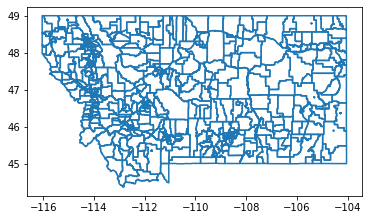

In [582]:
vest_mt_16.boundary.plot()

In [583]:
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for MT

In [584]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
mt_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Created `2016-General-Results-by-Precinct.csv` from `2016-General-Results-by-Precinct.xlsx` by opening in Excel and saving as a csv. No file modifications were made. 

In [585]:
#Load in clean SOS file
elections_2016 = pd.read_csv("./raw-from-source/MT_SOS/2016-General-Results-by-Precinct.csv")

In [586]:
elections_2016.shape

(31197, 21)

In [587]:
elections_2016.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Beaverhead,PRECINCT 01,PRESIDENT AND VICE PRESIDENT,DEM,175,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Beaverhead,PRECINCT 12,PRESIDENT AND VICE PRESIDENT,DEM,157,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beaverhead,PRECINCT 14,PRESIDENT AND VICE PRESIDENT,DEM,125,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Beaverhead,PRECINCT 17,PRESIDENT AND VICE PRESIDENT,DEM,18,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Beaverhead,PRECINCT 19,PRESIDENT AND VICE PRESIDENT,DEM,14,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare to Pivot Election Results

In [588]:
#Filter down to the offices we need
office_list = ['PRESIDENT AND VICE PRESIDENT','UNITED STATES REPRESENTATIVE','GOVERNOR & LT. GOVERNOR',
               'ATTORNEY GENERAL','SECRETARY OF STATE','STATE AUDITOR',
               'STATE SUPERINTENDENT OF PUBLIC INSTRUCTION']
elections_2016 = elections_2016[elections_2016["RaceName"].isin(office_list)]

In [589]:
elections_2016["NameOnBallot"].unique()

array(['HILLARY CLINTON AND TIM KAINE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG',
       'GARY JOHNSON AND BILL WELD', 'JILL STEIN AND AJAMU BARAKA',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'RICK BRECKENRIDGE',
       'DENISE JUNEAU', 'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER',
       'GREG GIANFORTE AND LESLEY ROBINSON', 'MONICA J. LINDEEN',
       'ROGER ROOTS', 'COREY STAPLETON', 'TIM FOX', 'LARRY JENT',
       'JESSE LASLOVICH', 'MATT ROSENDALE', 'ELSIE ARNTZEN',
       'MELISSA ROMANO'], dtype=object)

In [590]:
# Change column names to match the county fips dict
elections_2016.loc[elections_2016['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Map to the correct FIP
elections_2016["county"]=elections_2016["CountyName"].map(mt_fips_dict).fillna(elections_2016["CountyName"])

#Print out the FIPS to make sure they all are in the correct format
elections_2016["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [591]:
print(elections_2016["CountyName"].nunique())
print(len(mt_fips_dict))

56
56


In [592]:
#Clean up the precinct column by striping the white space
elections_2016["PrecinctName"]=elections_2016["PrecinctName"].str.strip()

#Create a column to pivot one by concatenating the FIPS with the precinct
elections_2016["pivot_col"]=elections_2016["county"]+elections_2016["PrecinctName"]

### Pivot Election Results

In [593]:
#Run the pivot
pivoted_2016 = pd.pivot_table(elections_2016,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill NA values w/ 0
pivoted_2016 = pivoted_2016.fillna(0)

#Clean the columns
pivoted_2016.reset_index(drop=False,inplace=True)
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)

In [594]:
#Print the df to get a sense for it
pivoted_2016.head()

NameOnBallot,,COREY STAPLETON,DENISE JUNEAU,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,GARY JOHNSON AND BILL WELD,GREG GIANFORTE AND LESLEY ROBINSON,HILLARY CLINTON AND TIM KAINE,JESSE LASLOVICH,JILL STEIN AND AJAMU BARAKA,...,MATT ROSENDALE,MELISSA ROMANO,MONICA J. LINDEEN,RICK BRECKENRIDGE,ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG,ROGER ROOTS,RYAN ZINKE,STEVE BULLOCK AND MIKE COONEY,TED DUNLAP AND RON VANDEVENDER,TIM FOX
0,001PRECINCT 01,229,205,203,196,48,176,175,229,15,...,208,236,193,22,1,23,230,267,15,275
1,001PRECINCT 02,540,178,551,511,35,482,127,244,16,...,476,212,161,27,4,32,546,249,23,600
2,001PRECINCT 03,524,186,507,469,32,470,158,257,5,...,443,236,184,17,0,18,532,252,15,587
3,001PRECINCT 04,123,41,131,121,6,109,34,48,1,...,118,48,41,6,0,2,128,60,4,143
4,001PRECINCT 05,100,16,99,91,4,99,9,21,1,...,92,22,14,2,0,3,100,17,2,105


In [595]:
pivoted_2016.columns

Index(['', 'COREY STAPLETON', 'DENISE JUNEAU',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'ELSIE ARNTZEN',
       'GARY JOHNSON AND BILL WELD', 'GREG GIANFORTE AND LESLEY ROBINSON',
       'HILLARY CLINTON AND TIM KAINE', 'JESSE LASLOVICH',
       'JILL STEIN AND AJAMU BARAKA', 'LARRY JENT', 'MATT ROSENDALE',
       'MELISSA ROMANO', 'MONICA J. LINDEEN', 'RICK BRECKENRIDGE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG', 'ROGER ROOTS',
       'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER', 'TIM FOX'],
      dtype='object', name='NameOnBallot')

In [596]:
#Rename the columns
pivoted_2016.columns = ["join_col",'G16SOSRSTA', 'G16HALDJUN',
       'G16PRERTRU', 'G16SPIRARN',
       'G16PRELJOH', 'G16GOVRGIA',
       'G16PREDCLI', 'G16AUDDLAS',
       'G16PREGSTE', 'G16ATGDJEN', 'G16AUDRROS',
       'G16SPIDROM', 'G16SOSDLIN', 'G16HALLBRE',
       'G16PREOFUE', 'G16SOSLROO',
       'G16HALRZIN', 'G16GOVDBUL',
       'G16GOVLDUN', 'G16ATGRFOX']

In [597]:
#Add in a column with the state, county and precinct name
pivoted_2016["STATEFP10"]="30"
pivoted_2016["COUNTYFP10"]=pivoted_2016["join_col"].str[0:3]
pivoted_2016["NAME"]=pivoted_2016["join_col"].str[3:]

In [598]:
pivoted_2016.head()

,join_col,G16SOSRSTA,G16HALDJUN,G16PRERTRU,G16SPIRARN,G16PRELJOH,G16GOVRGIA,G16PREDCLI,G16AUDDLAS,G16PREGSTE,...,G16HALLBRE,G16PREOFUE,G16SOSLROO,G16HALRZIN,G16GOVDBUL,G16GOVLDUN,G16ATGRFOX,STATEFP10,COUNTYFP10,NAME
0,001PRECINCT 01,229,205,203,196,48,176,175,229,15,...,22,1,23,230,267,15,275,30,001,PRECINCT 01
1,001PRECINCT 02,540,178,551,511,35,482,127,244,16,...,27,4,32,546,249,23,600,30,001,PRECINCT 02
2,001PRECINCT 03,524,186,507,469,32,470,158,257,5,...,17,0,18,532,252,15,587,30,001,PRECINCT 03
3,001PRECINCT 04,123,41,131,121,6,109,34,48,1,...,6,0,2,128,60,4,143,30,001,PRECINCT 04
4,001PRECINCT 05,100,16,99,91,4,99,9,21,1,...,2,0,3,100,17,2,105,30,001,PRECINCT 05


In [599]:
#Take a look at VEST's file
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

In [600]:
#Reorder the election result df's columns to match VEST's
pivoted_2016 = pivoted_2016[['STATEFP10', 'COUNTYFP10', 'NAME','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM',"join_col"]]

#Create a join column in the VEST file
vest_mt_16["join_col"]=vest_mt_16['COUNTYFP10']+vest_mt_16['NAME']

In [601]:
pivoted_2016.shape

(686, 24)

## Compare Election Results Totals

### Compare Total Votes

In [602]:
races = [x for x in vest_mt_16.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PREOFUE',
 'G16HALRZIN',
 'G16HALDJUN',
 'G16HALLBRE',
 'G16GOVRGIA',
 'G16GOVDBUL',
 'G16GOVLDUN',
 'G16ATGRFOX',
 'G16ATGDJEN',
 'G16SOSRSTA',
 'G16SOSDLIN',
 'G16SOSLROO',
 'G16AUDRROS',
 'G16AUDDLAS',
 'G16SPIRARN',
 'G16SPIDROM']

In [603]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_16[i])
    sum_var_2 += np.sum(pivoted_2016[i])
print(sum_var_1)
print(sum_var_2)

3481824
3481824


### Compare Race Totals

In [604]:
for race in races:
    diff_val = sum(vest_mt_16[race])-sum(pivoted_2016[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G16PRERTRU: EQUAL
G16PREDCLI: EQUAL
G16PRELJOH: EQUAL
G16PREGSTE: EQUAL
G16PREOFUE: EQUAL
G16HALRZIN: EQUAL
G16HALDJUN: EQUAL
G16HALLBRE: EQUAL
G16GOVRGIA: EQUAL
G16GOVDBUL: EQUAL
G16GOVLDUN: EQUAL
G16ATGRFOX: EQUAL
G16ATGDJEN: EQUAL
G16SOSRSTA: EQUAL
G16SOSDLIN: EQUAL
G16SOSLROO: EQUAL
G16AUDRROS: EQUAL
G16AUDDLAS: EQUAL
G16SPIRARN: EQUAL
G16SPIDROM: EQUAL


### Compare County Totals

In [605]:
diff_counties=[]
for i in races:
    diff = pivoted_2016.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_16.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(race, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(race + ' county totals: EQUAL')

G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL


### Check for Zero Vote Precincts in VEST

In [606]:
vest_mt_16[vest_mt_16['G16PRERTRU'] == 0]

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16ATGDJEN,G16SOSRSTA,G16SOSDLIN,G16SOSLROO,G16AUDRROS,G16AUDDLAS,G16SPIRARN,G16SPIDROM,geometry,join_col
389,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79807 48.22350, -113.79620 48.2...",029NA
390,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79240 48.38270, -113.79256 48.3...",029NA
682,30,047,Lake,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-114.03396 47.95345, -114.03355 47.9...",047NA


In [607]:
vest_mt_16['join_col'] = vest_mt_16['join_col'].str.upper()
pivoted_2016['join_col'] = pivoted_2016['join_col'].str.upper()

### Attempt to join the dataframes

In [608]:
join_attempt_one = pd.merge(vest_mt_16,pivoted_2016,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

left_only     465
right_only    462
both          224
Name: _merge, dtype: int64


In [609]:
join_attempt_one.columns

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY', 'NAME_x', 'SOSPRECINC',
       'G16PRERTRU_x', 'G16PREDCLI_x', 'G16PRELJOH_x', 'G16PREGSTE_x',
       'G16PREOFUE_x', 'G16HALRZIN_x', 'G16HALDJUN_x', 'G16HALLBRE_x',
       'G16GOVRGIA_x', 'G16GOVDBUL_x', 'G16GOVLDUN_x', 'G16ATGRFOX_x',
       'G16ATGDJEN_x', 'G16SOSRSTA_x', 'G16SOSDLIN_x', 'G16SOSLROO_x',
       'G16AUDRROS_x', 'G16AUDDLAS_x', 'G16SPIRARN_x', 'G16SPIDROM_x',
       'geometry', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'NAME_y',
       'G16PRERTRU_y', 'G16PREDCLI_y', 'G16PRELJOH_y', 'G16PREGSTE_y',
       'G16PREOFUE_y', 'G16HALRZIN_y', 'G16HALDJUN_y', 'G16HALLBRE_y',
       'G16GOVRGIA_y', 'G16GOVDBUL_y', 'G16GOVLDUN_y', 'G16ATGRFOX_y',
       'G16ATGDJEN_y', 'G16SOSRSTA_y', 'G16SOSDLIN_y', 'G16SOSLROO_y',
       'G16AUDRROS_y', 'G16AUDDLAS_y', 'G16SPIRARN_y', 'G16SPIDROM_y',
       '_merge'],
      dtype='object')

In [610]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTY','NAME_x','NAME_y','join_col']]

,COUNTY,NAME_x,NAME_y,join_col
2,Missoula,C S Porter 98,NaN,063C S PORTER 98
8,Missoula,E Missoula 92,NaN,063E MISSOULA 92
10,Missoula,Franklin 100 N,NaN,063FRANKLIN 100 N
11,Missoula,Franklin 100 S,NaN,063FRANKLIN 100 S
12,Missoula,Frenchtown 14 N,NaN,063FRENCHTOWN 14 N
13,Missoula,Frenchtown 14 S,NaN,063FRENCHTOWN 14 S
14,Missoula,Frenchtown 94,NaN,063FRENCHTOWN 94
15,Missoula,Frenchtown 96,NaN,063FRENCHTOWN 96
17,Missoula,Hawthorne 98 N,NaN,063HAWTHORNE 98 N
18,Missoula,Hawthorne 98 S,NaN,063HAWTHORNE 98 S


In [611]:
source_vest_names_dict = {'001PRECINCT 01': '001PRECINCT 1', 
                          '001PRECINCT 02': '001PRECINCT 2', 
                          '001PRECINCT 03': '001PRECINCT 3', 
                          '001PRECINCT 04': '001PRECINCT 4', 
                          '001PRECINCT 05': '001PRECINCT 5', 
                          '001PRECINCT 06': '001PRECINCT 6', 
                          '001PRECINCT 07': '001PRECINCT 7', 
                          '001PRECINCT 08': '001PRECINCT 8', 
                          '001PRECINCT 09': '001PRECINCT 9', 
                          '005TURNER 1-33': '005PRECINCT 1', 
                          '005SO CHINOOK 10-32': '005PRECINCT 10', 
                          '005CHINOOK 11-33': '005PRECINCT 11', 
                          '005NO CHINOOK 13-33': '005PRECINCT 13', 
                          '005HAYS 15-32': '005PRECINCT 15', 
                          '005BELKNAP 3-32': '005PRECINCT 3', 
                          '005HARLEM 8-32': '005PRECINCT 8', 
                          '005HARLEM 9-32': '005PRECINCT 9', 
                          '011PRECINCT #1 ALZADA': '011PRECINCT 1', 
                          '011PRECINCT #13 EKALAKA': '011PRECINCT 13', 
                          '011PRECINCT #14 RURAL EKALAKA': '011PRECINCT 14', 
                          '011PRECINCT #3 HAMMOND': '011PRECINCT 3', 
                          '013P22B.': '013P22B', 
                          '015BIG SANDY 8': '015BIG SANDY (#8)', 
                          '015BIG SANDY 9': '015BIG SANDY (#9)', 
                          '015CARTER 4': '015CARTER (#4)', 
                          '015FORT BENTON 1': '015FORT BENTON (#1)', 
                          '015FORT BENTON 2': '015FORT BENTON (#2)', 
                          '015GERALDINE 3': '015GERALDINE (#3)', 
                          '015HIGHWOOD 6': '015HIGHWOOD (#6)', 
                          '015LOMA 7': '015LOMA (#7)', 
                          '015ROCKY BOY 5': '015ROCKY BOY (#5)', 
                          '017HIGHLAND PARK SCH': '017HIGHLAND PARK', 
                          '017ISMAY CHURCH': '017ISMAY', 
                          '017JEFFERSON SCH': '017JEFFERSON', 
                          '017KNOWLTON SCH': '017KNOWLTON', 
                          '017RIVERVIEW SCHOOL': '017RIVERVIEW', 
                          '017SPRING CREEK SCH': '017SPRING CREEK', 
                          '017WASHINGTON SCH': '017WASHINGTON', 
                          '019PRECINCT #2': '019PRECINCT 2', 
                          '019PRECINCT #3': '019PRECINCT 3', 
                          '019PRECINCT #5': '019PRECINCT 5', 
                          '019PRECINCT #6': '019PRECINCT 6', 
                          '021PRECINCT 01': '021PRECINCT 1', 
                          '021PRECINCT 02': '021PRECINCT 2', 
                          '021PRECINCT 03': '021PRECINCT 3', 
                          '021PRECINCT 04': '021PRECINCT 4', 
                          '021PRECINCT 05': '021PRECINCT 5', 
                          '021PRECINCT 06': '021PRECINCT 6', 
                          '021PRECINCT 07': '021PRECINCT 7', 
                          '023PRECINCT 1-77E': '023PRECINCT 1-77 E', 
                          '023PRECINCT 1-77W': '023PRECINCT 1-77 W', 
                          '023PRECINCT 2-77E': '023PRECINCT 2-77 E', 
                          '023PRECINCT 2-77W': '023PRECINCT 2-77 W', 
                          '023PRECINCT 3-77E': '023PRECINCT 3-77 E', 
                          '023PRECINCT 3-77W': '023PRECINCT 3-77 W', 
                          '023PRECINCT 4-78E': '023PRECINCT 4-78 E', 
                          '023PRECINCT 4-78W': '023PRECINCT 4-78 W', 
                          '023PRECINCT 5-77N': '023PRECINCT 5-77 N', 
                          '023PRECINCT 5-77S': '023PRECINCT 5-77 S', 
                          '027PREC 10': '027PRECINCT 10', 
                          '027PREC 11': '027PRECINCT 11', 
                          '027PREC 12': '027PRECINCT 12', 
                          '027PREC 13': '027PRECINCT 13', 
                          '027PREC 14': '027PRECINCT 14', 
                          '027PREC 16': '027PRECINCT 16', 
                          '027PREC 17': '027PRECINCT 17', 
                          '027PREC 18': '027PRECINCT 18', 
                          '027PREC 2': '027PRECINCT 2', 
                          '027PREC 3': '027PRECINCT 3', 
                          '027PREC 4': '027PRECINCT 4', 
                          '027PREC 5': '027PRECINCT 5', 
                          '027PREC 6': '027PRECINCT 6', 
                          '027PREC 7': '027PRECINCT 7', 
                          '027PREC 8': '027PRECINCT 8', 
                          '027PREC 9': '027PRECINCT 9', 
                          '031PCT 59A': '03159A', 
                          '031PCT 61A': '03161A', 
                          '031PCT 61B': '03161B', 
                          '031PCT 61C': '03161C', 
                          '031PCT 61D': '03161D', 
                          '031PCT 62A': '03162A', 
                          '031PCT 62B': '03162B', 
                          '031PCT 62C': '03162C', 
                          '031PCT 62D': '03162D', 
                          '031PCT 63A': '03163A', 
                          '031PCT 63B': '03163B', 
                          '031PCT 63C': '03163C', 
                          '031PCT 64A': '03164A', 
                          '031PCT 64B': '03164B', 
                          '031PCT 64C': '03164C', 
                          '031PCT 64D': '03164D', 
                          '031PCT 65A': '03165A', 
                          '031PCT 65B': '03165B', 
                          '031PCT 65C': '03165C', 
                          '031PCT 66A': '03166A', 
                          '031PCT 66B': '03166B', 
                          '031PCT 66C': '03166C', 
                          '031PCT 67A': '03167A', 
                          '031PCT 67B': '03167B', 
                          '031PCT 67C': '03167C', 
                          '031PCT 68A': '03168A', 
                          '031PCT 68B': '03168B', 
                          '031PCT 68C': '03168C', 
                          '031PCT 69A': '03169A', 
                          '031PCT 69B': '03169B', 
                          '031PCT 69C': '03169C', 
                          '031PCT 69D': '03169D', 
                          '033PRECINCT 19': '033BRUSETT', 
                          '033PRECINCT 07': '033COHAGEN', 
                          '033PRECINCT 01': '033JORDAN', 
                          '033PRECINCT 14': '033SAND SPRINGS', 
                          '035PCT 01': '035PRECINCT 1', 
                          '035PCT 10': '035PRECINCT 10', 
                          '035PCT 11': '035PRECINCT 11', 
                          '035PCT 12': '035PRECINCT 12', 
                          '035PCT 13': '035PRECINCT 13', 
                          '035PCT 15': '035PRECINCT 15', 
                          '035PCT 19': '035PRECINCT 19', 
                          '035PCT 02': '035PRECINCT 2', 
                          '035PCT 21C': '035PRECINCT 21C', 
                          '035PCT 03': '035PRECINCT 3', 
                          '035PCT 04': '035PRECINCT 4', 
                          '035PCT 05': '035PRECINCT 5', 
                          '035PCT 06': '035PRECINCT 6', 
                          '035PCT 07': '035PRECINCT 7', 
                          '035PCT 08': '035PRECINCT 8', 
                          '035PCT 09': '035PRECINCT 9', 
                          '039PRECINCT #1': '039PRECINCT 1', 
                          '039PRECINCT #10': '039PRECINCT 10', 
                          '039PRECINCT #2': '039PRECINCT 2', 
                          '039PRECINCT #9': '039PRECINCT 9', 
                          '041PRECINCT #01': '041PRECINCT 1', 
                          '041PRECINCT #10': '041PRECINCT 10', 
                          '041PRECINCT #13': '041PRECINCT 13', 
                          '041PRECINCT #14': '041PRECINCT 14', 
                          '041PRECINCT #15': '041PRECINCT 15', 
                          '041PRECINCT #16': '041PRECINCT 16', 
                          '041PRECINCT #18': '041PRECINCT 18', 
                          '041PRECINCT #02': '041PRECINCT 2', 
                          '041PRECINCT #20': '041PRECINCT 20', 
                          '041PRECINCT #21': '041PRECINCT 21', 
                          '041PRECINCT #22': '041PRECINCT 22', 
                          '041PRECINCT #25': '041PRECINCT 25', 
                          '041PRECINCT #28': '041PRECINCT 28', 
                          '041PRECINCT #03': '041PRECINCT 3', 
                          '041PRECINCT #07': '041PRECINCT 7', 
                          '041PRECINCT #08': '041PRECINCT 8', 
                          '041PRECINCT #09': '041PRECINCT 9', 
                          '04301-71': '043PRECINCT 01-71 WHITEHALL', 
                          '04302-75': '043PRECINCT 02-75 WHITEHALL', 
                          '04303-75': '043PRECINCT 03-75 ELK PARK', 
                          '04304-75': '043PRECINCT 04-75 BOULDER', 
                          '04305-75': '043PRECINCT 05-75', 
                          '04306-75': '043PRECINCT 06-75 JEFFERSON CITY', 
                          '04307-75': '043PRECINCT 07-75 CLANCY', 
                          '04308-75': '043PRECINCT 08-75 CLANCY', 
                          '04309-75': '043PRECINCT 09-75 MONTANA CITY', 
                          '04310-75': '043PRECINCT 10-75 MONTANA CITY', 
                          '045PRECINCT 2': '045GEYSER', 
                          '045PRECINCT 4': '045HOBSON', 
                          '045PRECINCT 1': '045RAYNESFORD', 
                          '045PRECINCT 3': '045STANFORD', 
                          '047ARL 1 HD93': '047ARL1', 
                          '047BEA 1 HD10': '047BEA1', 
                          '047BEA 2 HD12': '047BEA2', 
                          '047CHA 1 HD93': '047CHA1', 
                          '047DAY 1 HD12': '047DAY1', 
                          '047FER 1 HD10': '047FER1', 
                          '047POL 1 HD12': '047POL1', 
                          '047POL 2 HD12': '047POL2', 
                          '047POL 3 HD12': '047POL3', 
                          '047POL 4 HD12': '047POL4', 
                          '047POL 5 HD12': '047POL5', 
                          '047POL 6 HD93': '047POL6', 
                          '047POL 7 HD93': '047POL7', 
                          '047POL 8 HD15': '047POL8', 
                          '047RON 1 HD93': '047RON1', 
                          '047RON 2 HD15': '047RON2', 
                          '047STI 1 HD93': '047STI1', 
                          '047STI 2 HD15': '047STI2', 
                          '047SWA 1 HD10': '047SWA1', 
                          '047SWA 2 HD15': '047SWA2', 
                          '049PCT 01': '0491', 
                          '049PCT 02': '0492', 
                          '049PCT 03': '0493', 
                          '049PCT 04': '0494', 
                          '049PCT 05': '0495', 
                          '049PCT 06': '0496', 
                          '049PCT 07': '0497', 
                          '049PCT 08': '0498', 
                          '049PCT 09': '0499', 
                          '049PCT 10': '04910', 
                          '049PCT 11': '04911', 
                          '049PCT 12': '04912', 
                          '049PCT 13': '04913', 
                          '049PCT 14': '04914', 
                          '049PCT 15': '04915', 
                          '049PCT 16': '04916', 
                          '049PCT 17': '04917', 
                          '049PCT 18': '04918', 
                          '049PCT 19': '04919', 
                          '049PCT 20': '04920', 
                          '049PCT 21': '04921', 
                          '049PCT 22': '04922', 
                          '049PCT 23': '04923', 
                          '049PCT 24': '04924', 
                          '049PCT 25': '04925', 
                          '049PCT 26': '04926', 
                          '049PCT 27': '04927', 
                          '049PCT 28': '04928', 
                          '049PCT 29': '04929', 
                          '049PCT 30': '04930', 
                          '049PCT 31': '04931', 
                          '049PCT 32': '04932', 
                          '049PCT 33': '04933', 
                          '049PCT 16A': '04916A', 
                          '049PCT 16B': '04916B', 
                          '049PCT 33A': '04933A', 
                          '049PCT 33B': '04933B', 
                          '051#1 PRECINCT - WEST': '051PRECINCT 1', 
                          '051#2 PRECINCT - NORTH': '051PRECINCT 2', 
                          '051#3 PRECINCT - SOUTH': '051PRECINCT 3', 
                          '051#4 PRECINCT - JOPLIN': '051PRECINCT 4', 
                          '053FORTINE': '0531 FORTINE', 
                          '053LIBBY NORTH': '05310 LIBBY NORTH', 
                          '053LIBBY EAST': '05311 LIBBY EAST', 
                          '053LIBBY WEST': '05312 LIBBY WEST', 
                          '053LIBBY/PLUMMER': '05313 LIBBY PLUMMER', 
                          '053TROY NORTH': '05314 TROY NORTH', 
                          '053TREGO': '0532 TREGO', 
                          '053EUREKA RURAL': '0533 GLEN LAKE REXFORD', 
                          '053TOWN OF EUREKA': '0534 TOWN OF EUREKA', 
                          '053YAAK': '0535 YAAK', 
                          '053MC CORMICK': '0536 MCCORMICK', 
                          '053TROY COMBINED': '0537 CITY OF TROY', 
                          '053TROY RURAL': '0538 TROY RURAL', 
                          '053CITY OF LIBBY': '0539 CITY OF LIBBY', 
                          '057ALDER - WARD 2': '057ALDER PRECINCT 1, WARD 2', 
                          '057ENNIS - RURAL': '057ENNIS RURAL PRECINCT 20', 
                          '057ENNIS - TOWN': '057ENNIS TOWN PRECINCT 21', 
                          '057HARRISON - WARD 2': '057HARRISON PRECINCT 15, WARD 2', 
                          '057JEFFERSON ISLAND - WARD 1': '057JEFFERSON ISLAND PRECINCT 15, WARD 1', 
                          '057SHERIDAN': '057SHERIDAN PRECINCT 5', 
                          '057TWIN BRIDGES': '057TWIN BRIDGES PRECINCT 7', 
                          '057VIRGINIA CITY - WARD 1': '057VIRGINIA CITY PRECINCT 1, WARD 1', 
                          '061ALBERTON': '061PRECINCT 22', 
                          '061SUPERIOR_24': '061PRECINCT 24', 
                          '061SUPERIOR_25': '061PRECINCT 25', 
                          '061ST. REGIS': '061PRECINCT 26', 
                          '061WEST END': '061PRECINCT 27', 
                          '061SUPERIOR_30': '061PRECINCT 30', 
                          '063CSPORTER 98': '063C S PORTER 98', 
                          '063EAST MSLA 92': '063E MISSOULA 92', 
                          '063FRANKLIN 100N': '063FRANKLIN 100 N', 
                          '063FRANKLIN 100S': '063FRANKLIN 100 S', 
                          '063FRENCHTWN 14N': '063FRENCHTOWN 14 N', 
                          '063FRENCHTWN 14S': '063FRENCHTOWN 14 S', 
                          '063FRENCHTWN 94': '063FRENCHTOWN 94', 
                          '063FRENCHTWN 96': '063FRENCHTOWN 96', 
                          '063HAWTHORNE 98N': '063HAWTHORNE 98 N', 
                          '063HAWTHORNE 98S': '063HAWTHORNE 98 S', 
                          '063HELLGATE 96E': '063HELLGATE 96 E', 
                          '063HELLGATE 96W': '063HELLGATE 96 W', 
                          '063LEWIS CLK 89': '063LEWIS & CLARK 89', 
                          '063LEWIS CLK 90E': '063LEWIS & CLARK 90 E', 
                          '063LEWIS CLK 90W': '063LEWIS & CLARK 90 W', 
                          '063PETTY CRK 97': '063PETTY CREEK 97', 
                          '063RATTLSNK 91E': '063RATTLESNAKE 91 E', 
                          '063RATTLSNK 91W': '063RATTLESNAKE 91 W', 
                          '063RUSSELL 99N': '063RUSSELL 99 N', 
                          '063RUSSELL 99S': '063RUSSELL 99 S', 
                          '063SEELEY LK 92': '063SEELEY 92', 
                          '063SENIOR CIT 91': '063SENIOR CITIZENS 91', 
                          '063SENIOR CIT 95': '063SENIOR CITIZENS 95', 
                          '063SPRING MDW 94': '063SPRING MEADOWS 94', 
                          '063SPRING MDW 96': '063SPRING MEADOWS 96', 
                          '063ST JOSEPH 100E': '063ST JOSEPH 100 E', 
                          '063ST JOSEPH 100W': '063ST JOSEPH 100 W', 
                          '063TARGET RNG 97': '063TARGET RANGE 97', 
                          '063TARGET RNG 98': '063TARGET RANGE 98', 
                          '063UC CENTR 89': '063U C 89', 
                          '06759A NORTH PC': '06759A', 
                          '06759B N CENTRAL PC': '06759B', 
                          '06759C S CENTRAL PC': '06759C', 
                          '06759D SOUTH PC': '06759D', 
                          '06760A NW OF LIVINGSTON': '06760A', 
                          '06760B SW OF LIVINGSTON': '06760B', 
                          '06760CL NW COL': '06760CL', 
                          '06760DL NE COL': '06760DL', 
                          '06760EL SE COL': '06760EL', 
                          '06760FL SC COL': '06760FL', 
                          '06760GL SW COL': '06760GL', 
                          '069PRECNCT 1': '069PRECINCT 1', 
                          '071PCT 11 - FIRST CREEK - 32/16': '07111 FIRST CREEK', 
                          '071PCT 12-N - MALTA NORTH - 33/17': '07112N MALTA COUNTRY NORTH', 
                          '071PCT 12-S - MALTA SOUTH - 32/16': '07112S MALTA COUNTRY SOUTH', 
                          '071PCT 16 - WHITEWATER - 33/17': '07116 WHITEWATER', 
                          '071PCT 2-N - DODSON NORTH - 33/17': '0712N DODSON NORTH', 
                          '071PCT 2-S - DODSON SOUTH - 32/16': '0712S DODSON SOUTH', 
                          '071PCT 5 - ZORTMAN - 32/16': '0715 ZORTMAN', 
                          '071PCT 6 - LANDUSKY - 32/16': '0716 LANDUSKY', 
                          '071PCT 7 - LORING - 33/17': '0717 LORING', 
                          '071PCT 8-N - SACO NORTH - 33/17': '0718N SACO NORTH', 
                          '071PCT 8-S - SACO SOUTH - 32/16': '0718S SACO SOUTH', 
                          '071PCT 9-1 - MALTA CITY - 33/17': '0719-1 MALTA CITY WARD 1', 
                          '071PCT 9-2 - MALTA CITY - 33/17': '0719-2 MALTA CITY WARD 2', 
                          '073BRADY_19': '073PRECINCT 19', 
                          '073HEART BUTTE_20': '073PRECINCT 20', 
                          '073DUPUYER_23': '073PRECINCT 23', 
                          '073CONRAD_24': '073PRECINCT 24', 
                          '073CONRAD_27': '073PRECINCT 27', 
                          '073CONRAD RURAL 29': '073PRECINCT 29', 
                          '073VALIER_34': '073PRECINCT 34', 
                          '073VALIER (RURAL)_35': '073PRECINCT 35', 
                          '075PRECINCT11': '075PRECINCT 11', 
                          '075PRECINCT12': '075PRECINCT 12', 
                          '075PRECINCT03': '075PRECINCT 3', 
                          '075PRECINCT04': '075PRECINCT 4', 
                          '075PRECINCT05': '075PRECINCT 5', 
                          '075PRECINCT08': '075PRECINCT 8', 
                          '075PRECINCT09': '075PRECINCT 9', 
                          '077PRECINCT #1.80': '077AVON PRECINCT #1', 
                          '077PRECINCT #3.78': '077COTTONWOOD CREEK PRECINCT #3', 
                          '077PRECINCT #8.80': '077ELLISTON PRECINCT #8', 
                          '077PRECINCT #10.80': '077GARRISON PRECINCT #10', 
                          '077PRECINCT #11.80': '077GOLD CREEK PRECINCT #11', 
                          '077PRECINCT #12.80': '077HELMVILLE PRECINCT #12', 
                          '077PRECINCT #14.80': '077OVANDO PRECINCT #14', 
                          '077PRECINCT #4.78': '077PRECINCT #4', 
                          '077PRECINCT #5.78': '077PRECINCT #5', 
                          '077PRECINCT #6.78': '077PRECINCT #6', 
                          '077PRECINCT #7.78': '077PRECINCT #7', 
                          '077PRECINCT #2.80': '077PRECINCT 2', 
                          '077PRECINCT #16.78': '077RACETRACK PRECINCT #16', 
                          '079PRECINCT NO. 1': '079PRECINCT 1', 
                          '079PRECINCT NO. 2': '079PRECINCT 2', 
                          '079PRECINCT NO. 3': '079PRECINCT 3', 
                          '079PRECINCT NO. 4': '079PRECINCT 4', 
                          '083PRECINCT 01': '083PRECINCT 1', 
                          '083PRECINCT 02': '083PRECINCT 2', 
                          '083PRECINCT 03': '083PRECINCT 3', 
                          '083PRECINCT 04': '083PRECINCT 4', 
                          '083PRECINCT 05': '083PRECINCT 5', 
                          '083PRECINCT 07': '083PRECINCT 7', 
                          '083PRECINCT 08': '083PRECINCT 8', 
                          '083PRECINCT 09': '083PRECINCT 9', 
                          '08502 BAINVILLE': '085BAINVILLE RURAL', 
                          '08515 BROCKTON': '085BROCKTON RURAL', 
                          '08512 CULBERTSON': '085CULBERTSON RURAL', 
                          '08522 EAST & NE WOLF POINT RURAL': '085EAST & NE WOLF POINT RURAL', 
                          '08516 EAST POPLAR RURAL': '085EAST POPLAR RURAL', 
                          '08510 FROID': '085FROID RURAL', 
                          '08517 NORTH POPLAR MINERAL BENCH': '085NORTH POPLAR RURAL', 
                          '08528 NORTH WOLF POINT RURAL (VICTORY)': '085NORTH WOLF POINT RURAL', 
                          '08518 POPLAR': '085POPLAR  RURAL', 
                          '08527 WEST WOLF POINT RURAL': '085WEST WOLF POINT RURAL', 
                          '08526 WOLF POINT NORTHSIDE': '085WOLF POINT NORTHSIDE', 
                          '08524 WOLF POINT SOUTHSIDE': '085WOLF POINT SOUTHSIDE', 
                          '0891-HERON-HD13': '0891-HERON - HD13', 
                          '0892-NOXON-HD13': '0892-NOXON - HD13', 
                          '0893-TROUT CREEK-HD13': '0893-TROUT CREEK - HD13', 
                          '0894-T FALLS-HD13': '0894-TFALLS - HD13', 
                          '0895-T FALLS-HD13': '0895-TFALLS - HD13', 
                          '0896-PLAINS-HD14': '0896-PLAINS - HD14', 
                          '0897-PLAINS-HD14': '0897-PLAINS - HD14', 
                          '0898-HOT SPRINGS-HD14': '0898-HOT SPRINGS - HD14', 
                          '0899-DIXON-HD14': '0899-DIXON - HD14', 
                          '0911 WESTBY': '091PRECINCT 1 - WESTBY', 
                          '0912 MEDICINE LAKE': '091PRECINCT 2 - MEDICINE LAKE', 
                          '0913 PLENTYWOOD WEST': '091PRECINCT 3 - PLENTYWOOD WEST', 
                          '0914 PLENTYWOOD EAST': '091PRECINCT 4 - PLENTYWOOD EAST', 
                          '0915 PLENTYWOOD RURAL WEST': '091PRECINCT 5 - PLENTYWOOD RURAL WEST', 
                          '0916 PLENTYWOOD RURAL EAST': '091PRECINCT 6 - PENTYWOOD RURAL EAST', 
                          '093PREC_1': '093PRECINCT 1', 
                          '093PREC_10N': '093PRECINCT 10N', 
                          '093PREC_10S': '093PRECINCT 10S', 
                          '093PREC_11': '093PRECINCT 11', 
                          '093PREC_12E': '093PRECINCT 12E', 
                          '093PREC_12W': '093PRECINCT 12W', 
                          '093PREC_14': '093PRECINCT 14', 
                          '093PREC_16': '093PRECINCT 16', 
                          '093PREC_17': '093PRECINCT 17', 
                          '093PREC_18': '093PRECINCT 18', 
                          '093PREC_19N': '093PRECINCT 19N', 
                          '093PREC_19S': '093PRECINCT 19S', 
                          '093PREC_19W': '093PRECINCT 19W', 
                          '093PREC_21': '093PRECINCT 21', 
                          '093PREC_22': '093PRECINCT 22', 
                          '093PREC_26E': '093PRECINCT 26E', 
                          '093PREC_26W': '093PRECINCT 26W', 
                          '093PREC_27N': '093PRECINCT 27N', 
                          '093PREC_27S': '093PRECINCT 27S', 
                          '093PREC_28': '093PRECINCT 28', 
                          '093PREC_29': '093PRECINCT 29', 
                          '093PREC_2E': '093PRECINCT 2E', 
                          '093PREC_2W': '093PRECINCT 2W', 
                          '093PREC_3': '093PRECINCT 3', 
                          '093PREC_4': '093PRECINCT 4', 
                          '093PREC_6': '093PRECINCT 6', 
                          '093PREC_8E': '093PRECINCT 8E', 
                          '093PREC_8W': '093PRECINCT 8W', 
                          '093PREC_9E': '093PRECINCT 9E', 
                          '093PREC_9N': '093PRECINCT 9N', 
                          '093PREC_9W': '093PRECINCT 9W', 
                          '095ABSAROKEE PRECINCT 13': '095ABSAROKEE', 
                          '095COLUMBUS PRECINCT 1': '095COLUMBUS', 
                          '095FISHTAIL PRECINCT 11': '095FISHTAIL', 
                          '095MOLT PRECINCT 7': '095MOLT', 
                          '095NYE PRECINCT 10': '095NYE', 
                          '095PARK CITY PRECINCT 2': '095PARK CITY', 
                          '095RAPELJE PRECINCT 9': '095RAPELJE', 
                          '095REED POINT PRECINCT 4': '095REED POINT', 
                          '099PRECINCT #1': '099PRECINCT 1', 
                          '099PRECINCT #11': '099PRECINCT 11', 
                          '099PRECINCT #17': '099PRECINCT 17', 
                          '099PRECINCT #6': '099PRECINCT 6', 
                          '099PRECINCT #7': '099PRECINCT 7', 
                          '101DEVON-GALATA': '101DEVON/GALATA', 
                          '103PRECINCT # 3': '103PRECINCT 3', 
                          '103PRECINCT # 4': '103PRECINCT 4', 
                          '103PRECINCT # 6': '103PRECINCT 6', 
                          '1051-FORT PECK': '105FORT PECK', 
                          '1052-FRAZER': '105FRAZER', 
                          '1054-GLASGOW': '105GLASGOW', 
                          '1055-GLASGOW NE': '105GLASGOW NORTHEAST', 
                          '1053-HINSDALE': '105HINSDALE', 
                          '1057-LUSTRE': '105LUSTRE', 
                          '1056-NASHUA': '105NASHUA', 
                          '1058-OPHEIM': '105OPHEIM', 
                          '109PRECINCT #1': '109PRECINCT 1'}

#Use the dictionary to change the names
pivoted_2016["join_col"]=pivoted_2016["join_col"].map(source_vest_names_dict).fillna(pivoted_2016["join_col"])

### Join Attempt 2

In [612]:
join_attempt_two = pd.merge(vest_mt_16,pivoted_2016,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          654
left_only      35
right_only     32
Name: _merge, dtype: int64


In [613]:
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTY','NAME_x','NAME_y','join_col']]

,COUNTY,NAME_x,NAME_y,join_col
64,Big Horn,PERITSA,NaN,003PERITSA
74,Carbon,Rockvale / Silesia,NaN,009ROCKVALE / SILESIA
81,Big Horn,KIRBY DECKER,NaN,003KIRBY DECKER
84,Carbon,Red Lodge - Ward 3,NaN,009RED LODGE - WARD 3
96,Carbon,Red Lodge Rural,NaN,009RED LODGE RURAL
115,Big Horn,WYOLA,NaN,003WYOLA
117,Carbon,Fromberg / Edgar,NaN,009FROMBERG / EDGAR
124,Big Horn,PRYOR,NaN,003PRYOR
125,Carbon,Luther / Roscoe,NaN,009LUTHER / ROSCOE
131,Big Horn,HARDIN,NaN,003HARDIN


## Unmatched Precincts

Precincts from Big Horn and Carbon counties could not be matched. The county race totals matched but we were unable to check precinct levels for these counties.

### Compare Precinct Votes

In [614]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [615]:
validater_row(join_attempt_two.sort_values("join_col"),races)


There are  721  total rows
0  of these rows have election result differences
721  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


# Precinct Shapefile

## Load in the shapefiles

### Shp from SOS

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the shapefile from the SOS: https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7bdbd29997-21d8-4af1-9d87-5c5134775995%7d
Navigate to "Download Data", select "MontanaVotingPrecincts_shp.zip". 

Confirming whether this file is the same as the TIGER/Line file. 

In [616]:
mt_shp = gp.read_file('./raw-from-source/MT_SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [617]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [618]:
print(mt_shp.shape)
vest_mt_16.shape

(666, 17)


(689, 27)

In [619]:
mt_shp.crs

<Projected CRS: EPSG:32100>
Name: NAD83 / Montana
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Montana - counties of Beaverhead; Big Horn; Blaine; Broadwater; Carbon; Carter; Cascade; Chouteau; Custer; Daniels; Dawson; Deer Lodge; Fallon; Fergus; Flathead; Gallatin; Garfield; Glacier; Golden Valley; Granite; Hill; Jefferson; Judith Basin; Lake; Lewis and Clark; Liberty; Lincoln; Madison; McCone; Meagher; Mineral; Missoula; Musselshell; Park; Petroleum; Phillips; Pondera; Powder River; Powell; Prairie; Ravalli; Richland; Roosevelt; Rosebud; Sanders; Sheridan; Silver Bow; Stillwater; Sweet Grass; Teton; Toole; Treasure; Valley; Wheatland; Wibaux; Yellowstone.
- bounds: (-116.07, 44.35, -104.04, 49.01)
Coordinate Operation:
- name: SPCS83 Montana zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [620]:
vest_mt_16 = vest_mt_16.to_crs(epsg=32100)

<AxesSubplot:>

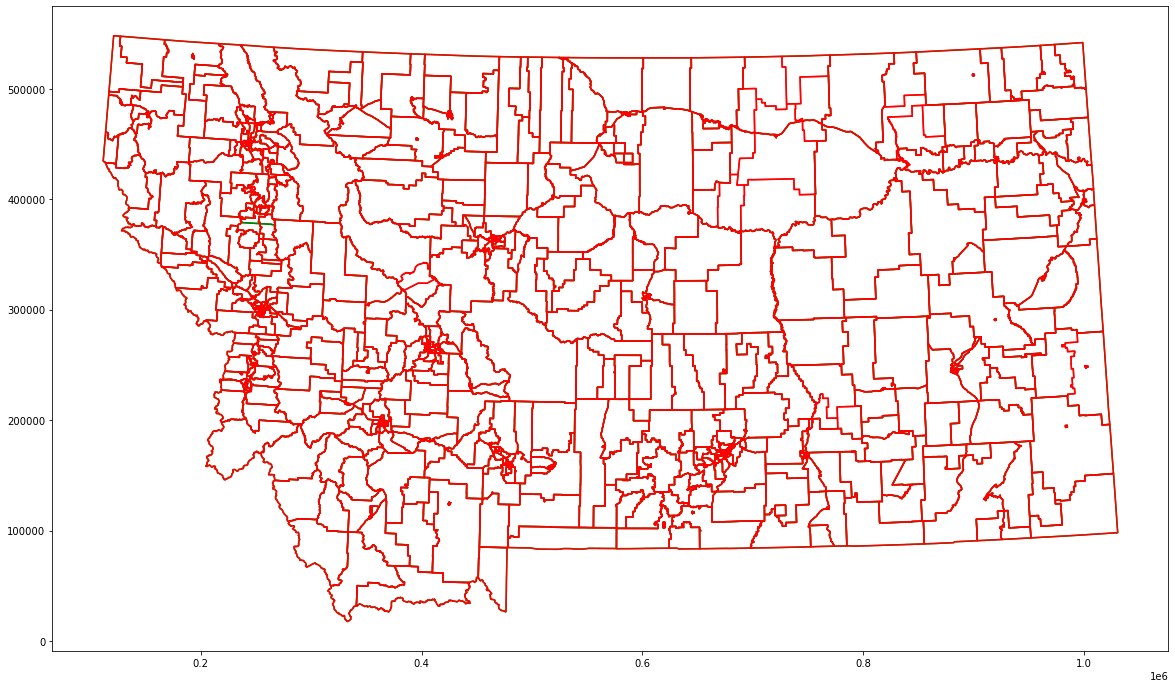

In [621]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_16.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [622]:
#Add a join column to the source shapefile
mt_shp["join_col"]=mt_shp['COUNTYFP10']+mt_shp['NAME']
mt_shp

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52...",051#1 Precinct - West
1,000001,1-HERON-HD13,13,7,HERON COMMUNITY CENTER,Sanders,35,30,089,COUNTY GIS DATA,2018-10-23,3750,#1,45,89108.059261,2.808293e+08,"POLYGON ((114102.250 461041.840, 114155.020 46...",0891-HERON-HD13
2,000001,1 WESTBY,34,17,WESTBY COMMUNITY HALL,Sheridan,34,30,091,DIGITIZED FROM COUNTY MAP,2019-06-21,4518,1_PREC,46,152033.377796,7.430864e+08,"POLYGON ((998562.006 541713.323, 998580.694 54...",0911 WESTBY
3,000001,COLUMBUS PRECINCT 1,57,29,STILLWATER PAVILLION,Stillwater,32,30,095,COUNTY GIS DATA,2019-08-01,2337,PREC_1,48,210565.225728,9.073550e+08,"POLYGON ((616112.063 176124.484, 616516.128 17...",095COLUMBUS PRECINCT 1
4,000001,FORT BENTON 1,27,14,FORT BENTON ELEMENTARY,Chouteau,19,30,015,DIGITIZED FROM COUNTY MAP,2018-09-18,1596,PCT_01,08,109711.564255,4.525434e+08,"POLYGON ((518671.300 403468.700, 518742.000 40...",015FORT BENTON 1
5,000001,FORTINE,2,1,TREGO-FORTINE-STRYKER VOLUNTEER FIRE DEPARTMENT,Lincoln,56,30,053,COUNTY GIS DATA,2018-12-12,4198,1_PREC,27,77785.351886,2.253139e+08,"POLYGON ((195242.150 521890.267, 195385.518 52...",053FORTINE
6,000001,P 1,58,29,P1 JOLIET COMMUNITY CENTER,Carbon,10,30,009,ARCGIS ONLINE GIS DATA,2016-12-09,2397,001,05,87177.755009,1.655472e+08,"POLYGON ((655964.106 154250.571, 655968.250 15...",009P 1
7,000001,PCT 01,18,9,CB VOTING CENTER 01,Glacier,38,30,035,COUNTY GIS DATA,2019-09-04,5362,PCT 01,18,5746.390351,6.414525e+05,"POLYGON ((391754.379 490817.885, 391765.769 49...",035PCT 01
8,000001,PCT 01,81,41,JIM DARCY SCHOOL,Lewis and Clark,5,30,049,COUNTY GIS DATA,2019-06-20,0252,P01,25,17172.467945,1.274513e+07,"POLYGON ((404133.830 275921.161, 404168.659 27...",049PCT 01
9,000001,PCT 01,85,43,DARBY SCHOOL GYM,Ravalli,13,30,081,COUNTY GIS DATA,2017-12-08,2867,01_PCT,41,311835.532128,2.328979e+09,"POLYGON ((240673.188 202052.224, 240711.232 20...",081PCT 01


## **Attempt to join dataframes**

In [623]:
join_attempt_shape1 = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator=True)
print(join_attempt_shape1["_merge"].value_counts())
join_attempt_shape1.columns

right_only    466
left_only     443
both          225
Name: _merge, dtype: int64


Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN', 'G16HALDJUN', 'G16HALLBRE',
       'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN', 'G16ATGRFOX', 'G16ATGDJEN',
       'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO', 'G16AUDRROS', 'G16AUDDLAS',
       'G16SPIRARN', 'G16SPIDROM', 'geometry_y', '_merge'],
      dtype='object')

In [624]:
mt_shp["join_col"]=mt_shp["join_col"].str.upper()
#Use the dictionary to change the names
mt_shp["join_col"]=mt_shp["join_col"].map(source_vest_names_dict).fillna(mt_shp["join_col"])

In [625]:
dict2 = {'053CITY OF TROY':'0537 CITY OF TROY','057HARRISON': '057HARRISON PRECINCT 15, WARD 2','057JEFF ISLAND': '057JEFFERSON ISLAND PRECINCT 15, WARD 1','057ALDER': '057ALDER PRECINCT 1, WARD 2','057VIRGINIA CITY': '057VIRGINIA CITY PRECINCT 1, WARD 1'}
mt_shp["join_col"]=mt_shp["join_col"].map(dict2).fillna(mt_shp["join_col"])

## **Join attempt 2**

In [626]:
join_attempt_shape2 = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator=True)
print(join_attempt_shape2["_merge"].value_counts())

both          628
right_only     63
left_only      40
Name: _merge, dtype: int64


In [627]:
pd.set_option('display.max_rows', None)
join_attempt_shape2[join_attempt_shape2['_merge'] != 'both'][['COUNTY_x','NAME_x','COUNTY_y','NAME_y','join_col']]

,COUNTY_x,NAME_x,COUNTY_y,NAME_y,join_col
6,Carbon,P 1,NaN,NaN,009P 1
14,Big Horn,PRECINCT #1,NaN,NaN,003PRECINCT #1
22,Treasure,Precinct 1,NaN,NaN,103PRECINCT 1
42,Carbon,P 2,NaN,NaN,009P 2
50,Big Horn,PRECINCT #2,NaN,NaN,003PRECINCT #2
69,Carbon,P 3,NaN,NaN,009P 3
77,Big Horn,PRECINCT #3,NaN,NaN,003PRECINCT #3
96,Carbon,P 4,NaN,NaN,009P 4
102,Big Horn,PRECINCT #4,NaN,NaN,003PRECINCT #4
119,Carbon,P 5,NaN,NaN,009P 5


<AxesSubplot:>

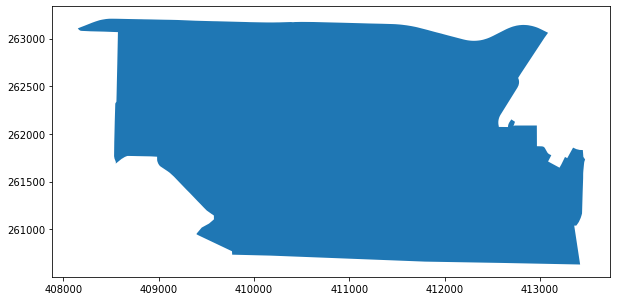

In [628]:
mt_shp[mt_shp['join_col'] =='04916'].plot(figsize=(10,10))

<AxesSubplot:>

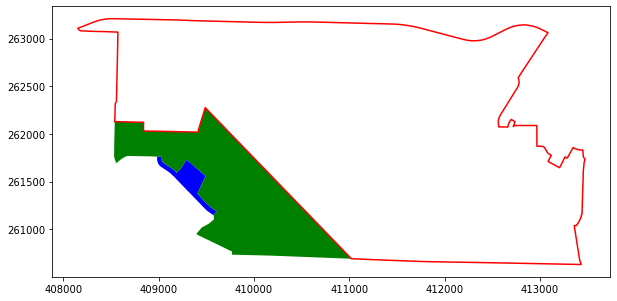

In [629]:
ax = vest_mt_16[vest_mt_16['join_col'] == '04916'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '04916A'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '04916B'].plot(ax=ax, color='green')

<AxesSubplot:>

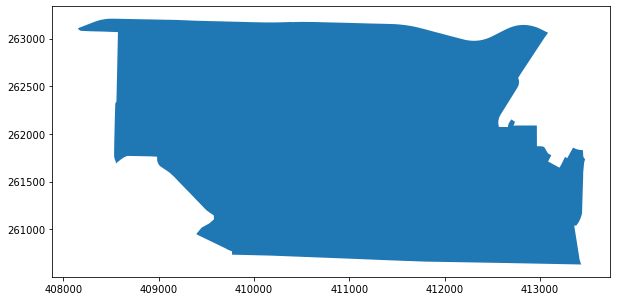

In [630]:
#Merge precinct 16A, and 16B into 16
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="04916"],vest_mt_16.loc[vest_mt_16["join_col"]=="04916A"],vest_mt_16.loc[vest_mt_16["join_col"]=="04916B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="04916","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="04916A"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="04916B"]
vest_mt_16[vest_mt_16['join_col'] =='04916'].plot(figsize=(10,10))

<AxesSubplot:>

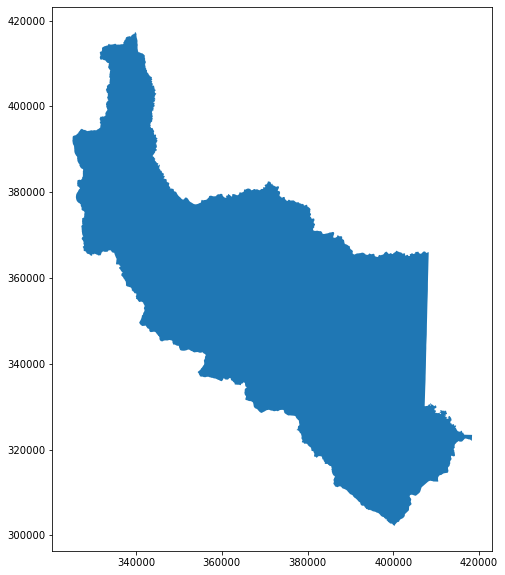

In [631]:
mt_shp[mt_shp['join_col'] =='04933'].plot(figsize=(10,10))

<AxesSubplot:>

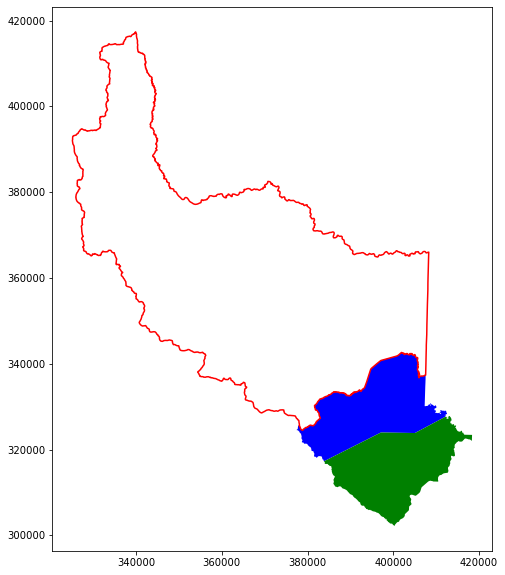

In [632]:
ax = vest_mt_16[vest_mt_16['join_col'] == '04933'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '04933A'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '04933B'].plot(ax=ax, color='green')

<AxesSubplot:>

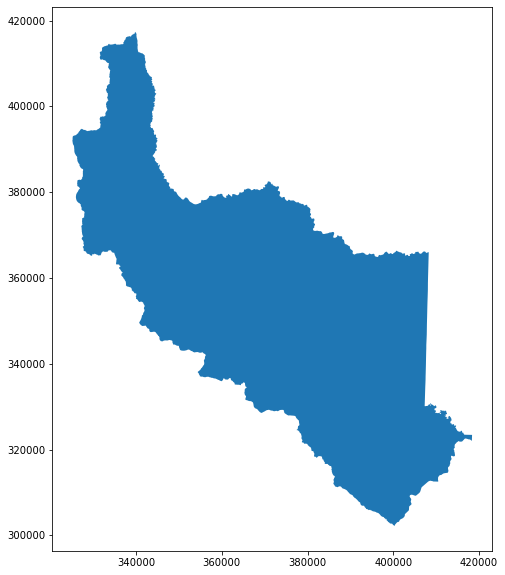

In [633]:
#Merge precinct 33A, and 33B into 33
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="04933"],vest_mt_16.loc[vest_mt_16["join_col"]=="04933A"],vest_mt_16.loc[vest_mt_16["join_col"]=="04933B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="04933","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="04933A"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="04933B"]
vest_mt_16[vest_mt_16['join_col'] =='04933'].plot(figsize=(10,10))

<AxesSubplot:>

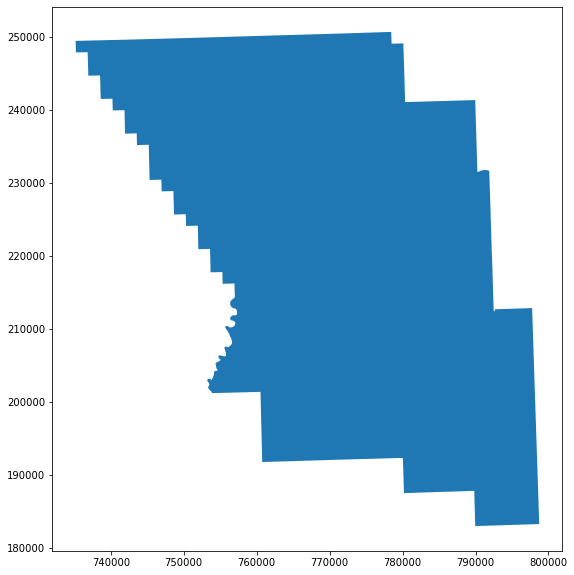

In [634]:
mt_shp[mt_shp['join_col'] =='103PRECINCT 1'].plot(figsize=(10,10))

(685, 27)

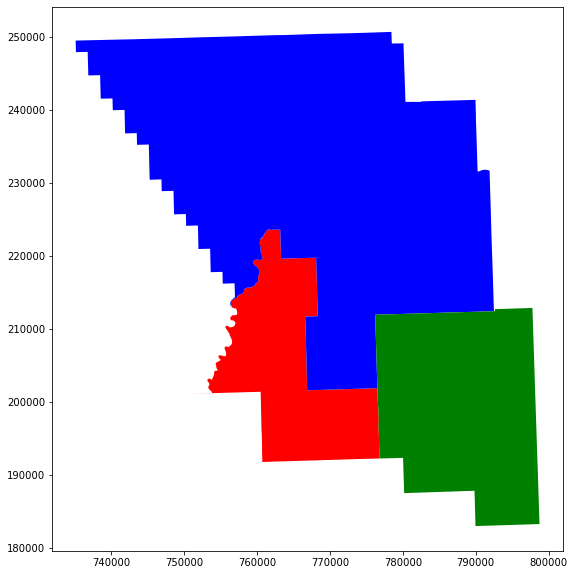

In [635]:
ax = vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT 3'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT 4'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT 6'].plot(ax=ax, color='green')
vest_mt_16.shape

<AxesSubplot:>

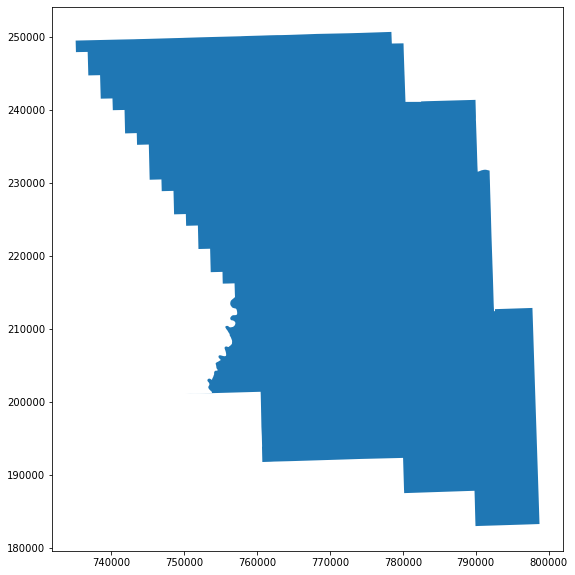

In [636]:
#Merge Treasure precinct 3, 4, and 6 into 1
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT 3"],vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT 4"],vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT 6"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT 3","join_col"]='103PRECINCT 1'
vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT 1","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="103PRECINCT 4"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="103PRECINCT 6"]
vest_mt_16[vest_mt_16['join_col'] =='103PRECINCT 1'].plot(figsize=(10,10))

<AxesSubplot:>

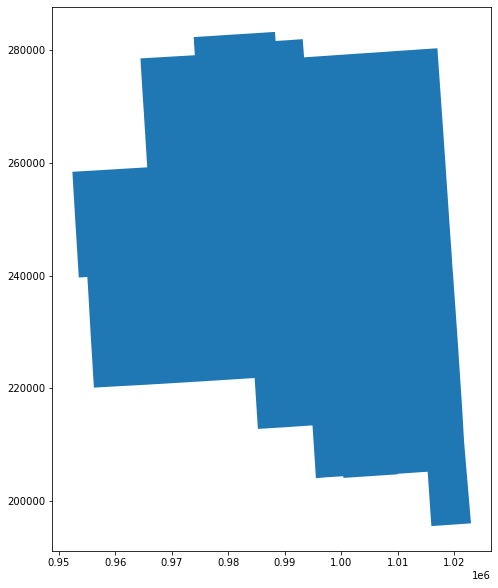

In [637]:
mt_shp[mt_shp['join_col'] =='025PRECINCT 1'].plot(figsize=(10,10))

<AxesSubplot:>

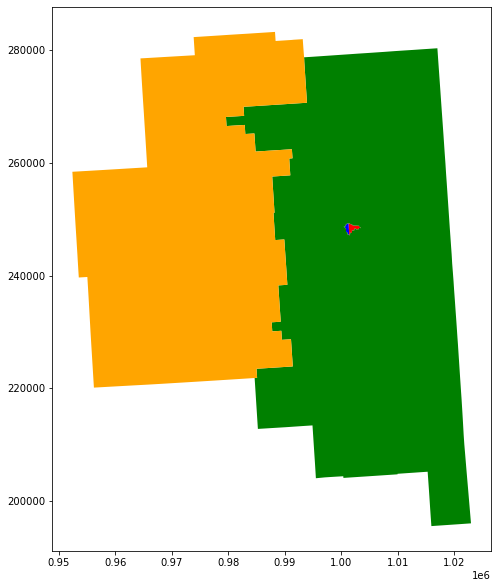

In [638]:
ax = vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 1'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 2'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 3'].plot(ax=ax, color='green')
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 4'].plot(ax=ax, color='orange')

<AxesSubplot:>

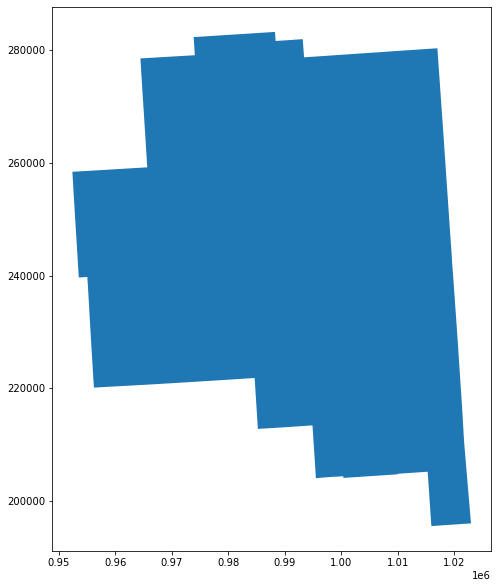

In [639]:
#Merge Fallon precinct 1, 2, 3 and 4 into 1
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 1"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 2"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 3"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 4"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 1","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 2"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 3"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 4"]
vest_mt_16[vest_mt_16['join_col'] =='025PRECINCT 1'].plot(figsize=(10,10))

<AxesSubplot:>

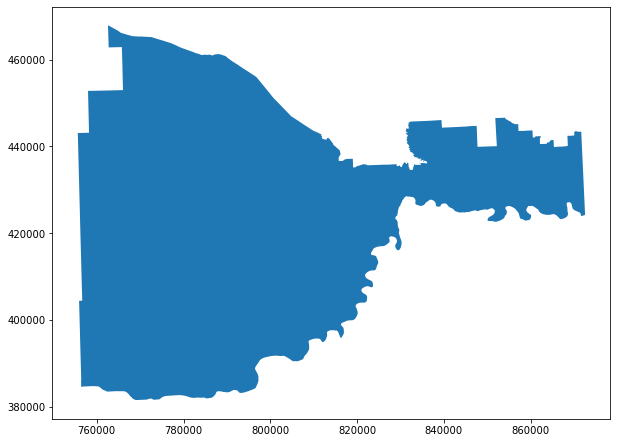

In [640]:
mt_shp[mt_shp['join_col'] =='10531 FTP FRZ'].plot(figsize=(10,10))

<AxesSubplot:>

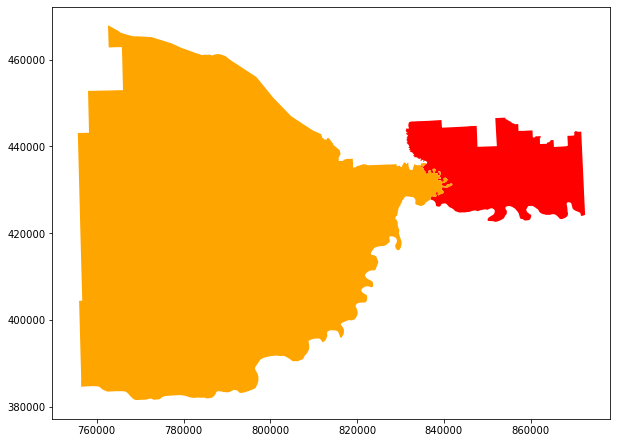

In [641]:
ax = vest_mt_16[vest_mt_16['join_col'] == '105FRAZER'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '105FORT PECK'].plot(ax=ax, color='orange')

<AxesSubplot:>

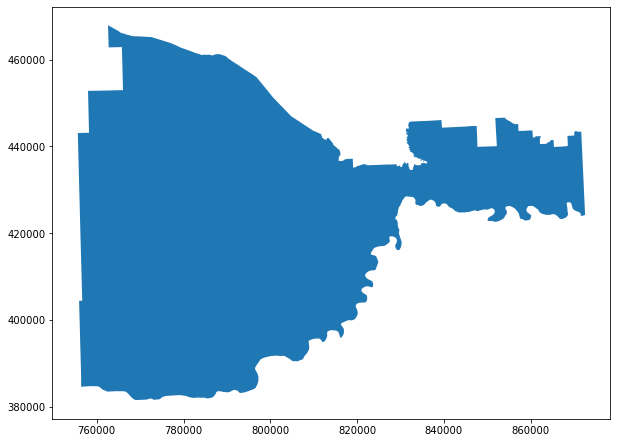

In [657]:
#Merge precinct FRAZER and FORT PECK into 31 FTP FRZ
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="105FRAZER"],vest_mt_16.loc[vest_mt_16["join_col"]=="105FORT PECK"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="105FRAZER","join_col"]='10531 FTP FRZ'
vest_mt_16.loc[vest_mt_16["join_col"]=="10531 FTP FRZ","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="105FORT PECK"]
vest_mt_16[vest_mt_16['join_col'] =='10531 FTP FRZ'].plot(figsize=(10,10))

<AxesSubplot:>

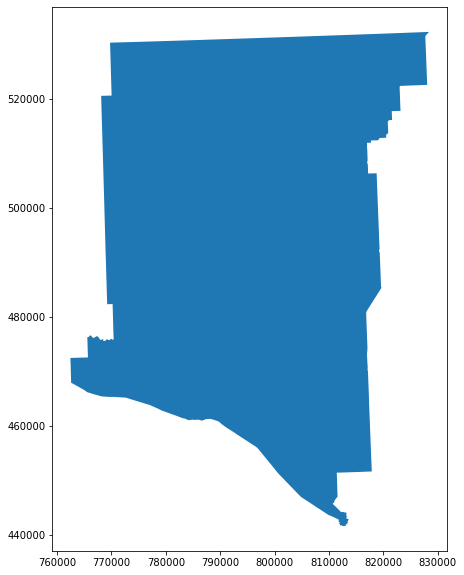

In [642]:
mt_shp[mt_shp['join_col'] =='10533 GLS HIN'].plot(figsize=(10,10))

<AxesSubplot:>

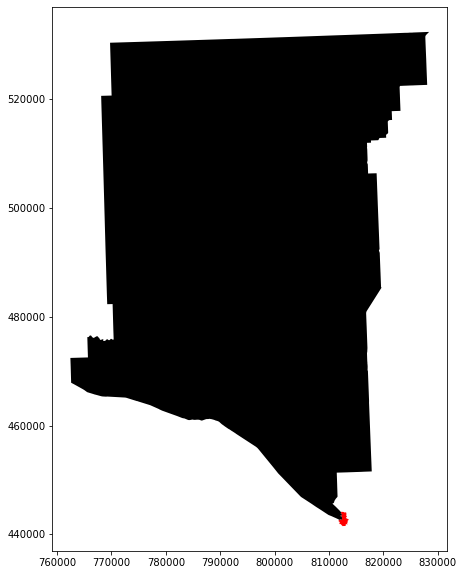

In [643]:
ax = vest_mt_16[vest_mt_16['join_col'] == '105GLASGOW'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '105HINSDALE'].plot(ax=ax, color='black')

<AxesSubplot:>

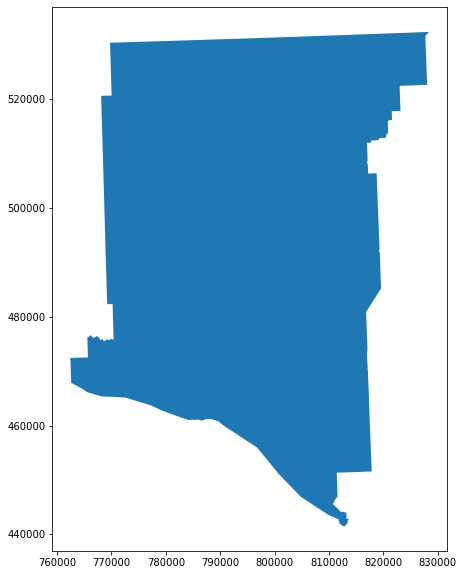

In [644]:
#Merge precinct GLASGOW and HINSDALE into 33 GLS HIN
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="105GLASGOW"],vest_mt_16.loc[vest_mt_16["join_col"]=="105HINSDALE"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="105GLASGOW","join_col"]='10533 GLS HIN'
vest_mt_16.loc[vest_mt_16["join_col"]=="10533 GLS HIN","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="105HINSDALE"]
vest_mt_16[vest_mt_16['join_col'] =='10533 GLS HIN'].plot(figsize=(10,10))

<AxesSubplot:>

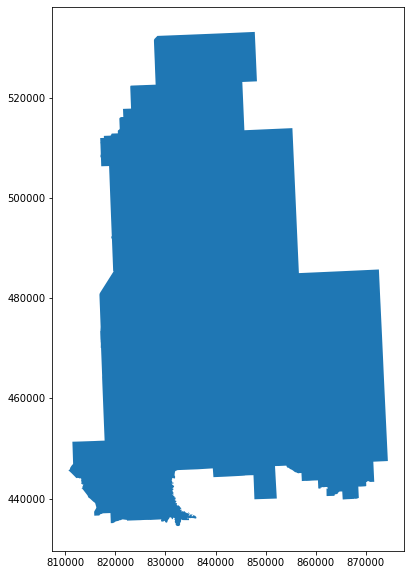

In [645]:
mt_shp[mt_shp['join_col'] =='10534 LUS OPH NAS GNE'].plot(figsize=(10,10))

<AxesSubplot:>

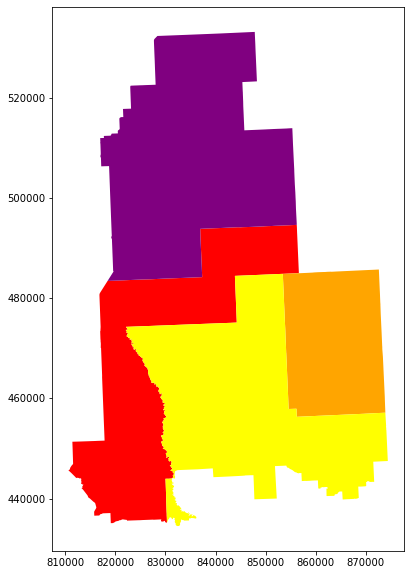

In [646]:
ax = vest_mt_16[vest_mt_16['join_col'] == '105GLASGOW NORTHEAST'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '105LUSTRE'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '105NASHUA'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '105OPHEIM'].plot(ax=ax, color='purple')

<AxesSubplot:>

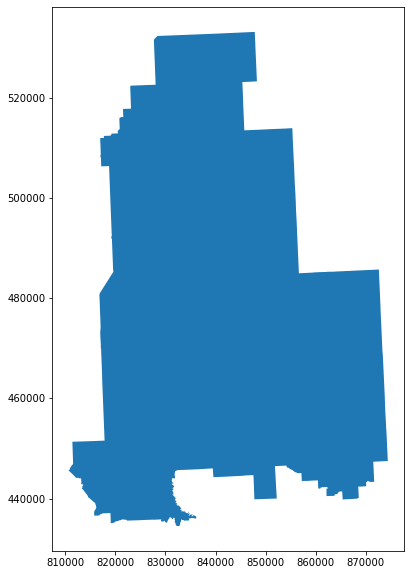

In [647]:
#Merge precinct GLASGOW NORTHEAST, LUSTRE, NASHUA, and OPHEIM into 34 LUS OPH NAS GNE
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="105GLASGOW NORTHEAST"],vest_mt_16.loc[vest_mt_16["join_col"]=="105LUSTRE"],vest_mt_16.loc[vest_mt_16["join_col"]=="105NASHUA"],vest_mt_16.loc[vest_mt_16["join_col"]=="105OPHEIM"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="105GLASGOW NORTHEAST","join_col"]='10534 LUS OPH NAS GNE'
vest_mt_16.loc[vest_mt_16["join_col"]=="10534 LUS OPH NAS GNE","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="105LUSTRE"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="105NASHUA"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="105OPHEIM"]
vest_mt_16[vest_mt_16['join_col'] =='10534 LUS OPH NAS GNE'].plot(figsize=(10,10))

<AxesSubplot:>

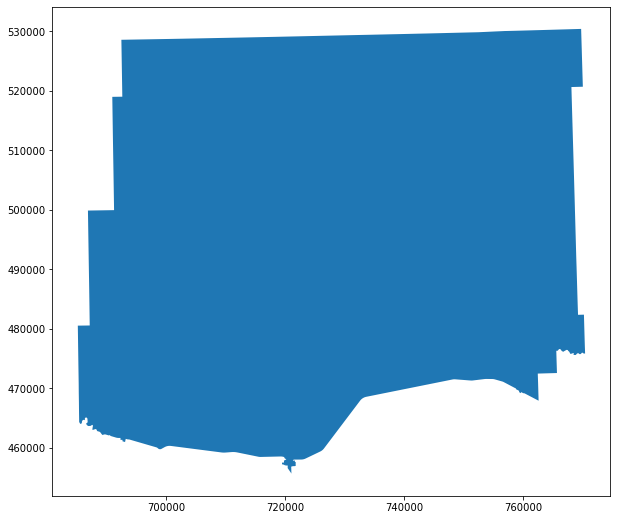

In [648]:
mt_shp[mt_shp['join_col'] =='071PCT 11N - PHILLIPS - 33/17'].plot(figsize=(10,10))

<AxesSubplot:>

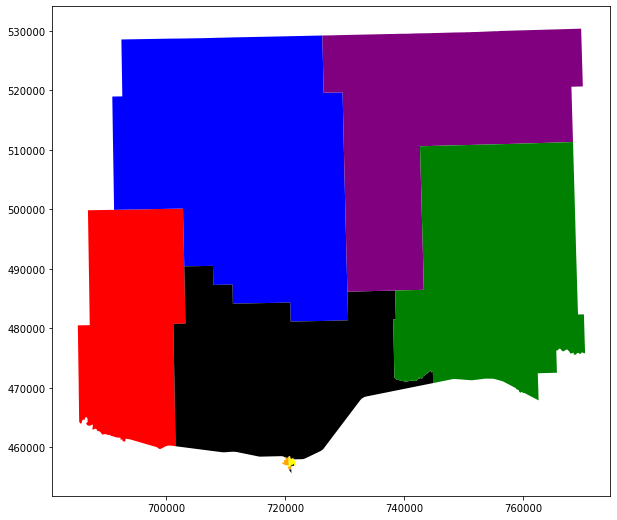

In [649]:
ax = vest_mt_16[vest_mt_16['join_col'] == '0712N DODSON NORTH'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '0717 LORING'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '0719-1 MALTA CITY WARD 1'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '0719-2 MALTA CITY WARD 2'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '07112N MALTA COUNTRY NORTH'].plot(ax=ax, color='black')
vest_mt_16[vest_mt_16['join_col'] == '07116 WHITEWATER'].plot(ax=ax, color='purple')
vest_mt_16[vest_mt_16['join_col'] == '0718N SACO NORTH'].plot(ax=ax, color='green')

<AxesSubplot:>

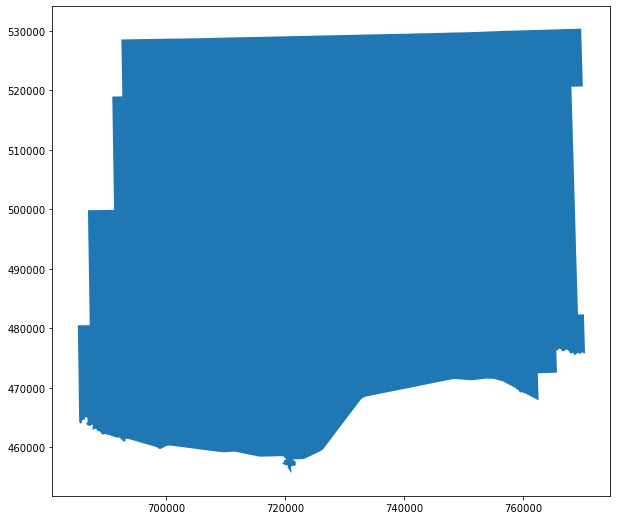

In [650]:
#Merge precinct 2N DODSON NORTH, 7 LORING, 9-1 MALTA CITY WARD 1, 9-2 MALTA CITY WARD 2, 12N MALTA COUNTRY NORTH, 16 WHITEWATER, and 8N SACO NORTH into PCT 11N - PHILLIPS - 33/17
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="0712N DODSON NORTH"],vest_mt_16.loc[vest_mt_16["join_col"]=="0717 LORING"],vest_mt_16.loc[vest_mt_16["join_col"]=="0719-1 MALTA CITY WARD 1"],vest_mt_16.loc[vest_mt_16["join_col"]=="0719-2 MALTA CITY WARD 2"],vest_mt_16.loc[vest_mt_16["join_col"]=="07112N MALTA COUNTRY NORTH"],vest_mt_16.loc[vest_mt_16["join_col"]=="07116 WHITEWATER"],vest_mt_16.loc[vest_mt_16["join_col"]=="0718N SACO NORTH"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="0712N DODSON NORTH","join_col"]='071PCT 11N - PHILLIPS - 33/17'
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 11N - PHILLIPS - 33/17","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0717 LORING"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0719-1 MALTA CITY WARD 1"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0719-2 MALTA CITY WARD 2"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="07112N MALTA COUNTRY NORTH"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="07116 WHITEWATER"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0718N SACO NORTH"]
vest_mt_16[vest_mt_16['join_col'] =='071PCT 11N - PHILLIPS - 33/17'].plot(figsize=(10,10))

<AxesSubplot:>

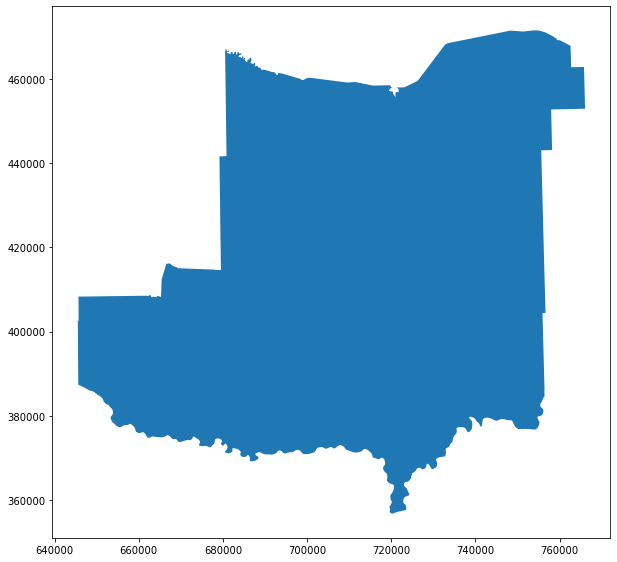

In [651]:
mt_shp[mt_shp['join_col'] =='071PCT 11S - PHILLIPS - 32/16'].plot(figsize=(10,10))

<AxesSubplot:>

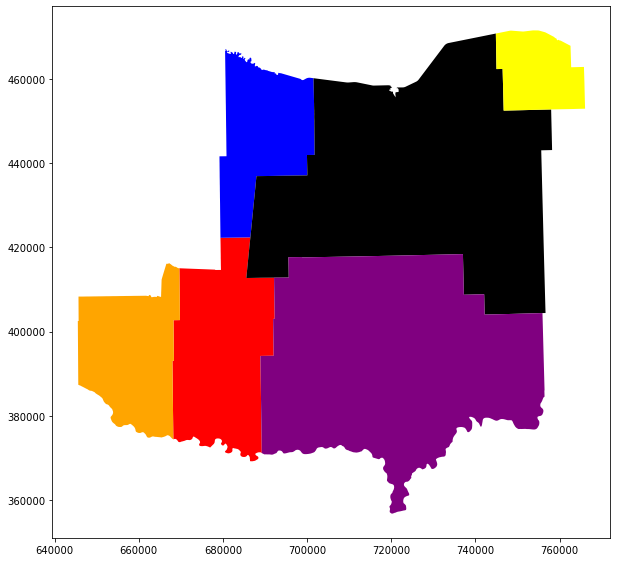

In [652]:
ax = vest_mt_16[vest_mt_16['join_col'] == '0715 ZORTMAN'].plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '0716 LANDUSKY'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '0712S DODSON SOUTH'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '07112S MALTA COUNTRY SOUTH'].plot(ax=ax, color='black')
vest_mt_16[vest_mt_16['join_col'] == '0718S SACO SOUTH'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '07111 FIRST CREEK'].plot(ax=ax, color='purple')

<AxesSubplot:>

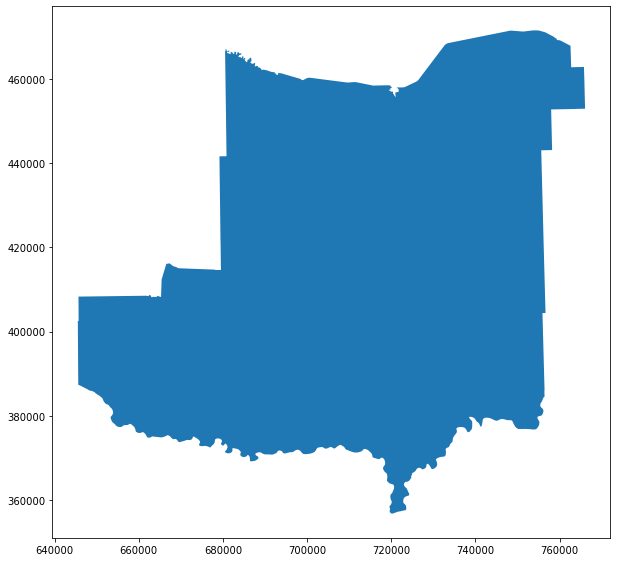

In [653]:
#Merge precinct 5 ZORTMAN, 6 LANDUSKY, 2S DODSON SOUTH, 12S MALTA COUNTRY SOUTH, 8S SACO SOUTH, and 11 FIRST CREEK into PCT 11S - PHILLIPS - 32/16
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="0715 ZORTMAN"],vest_mt_16.loc[vest_mt_16["join_col"]=="0716 LANDUSKY"],vest_mt_16.loc[vest_mt_16["join_col"]=="0712S DODSON SOUTH"],vest_mt_16.loc[vest_mt_16["join_col"]=="07112S MALTA COUNTRY SOUTH"],vest_mt_16.loc[vest_mt_16["join_col"]=="0718S SACO SOUTH"],vest_mt_16.loc[vest_mt_16["join_col"]=="07111 FIRST CREEK"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="0715 ZORTMAN","join_col"]='071PCT 11S - PHILLIPS - 32/16'
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 11S - PHILLIPS - 32/16","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0716 LANDUSKY"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0712S DODSON SOUTH"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="07112S MALTA COUNTRY SOUTH"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="0718S SACO SOUTH"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="07111 FIRST CREEK"]
vest_mt_16[vest_mt_16['join_col'] =='071PCT 11S - PHILLIPS - 32/16'].plot(figsize=(10,10))

In [706]:
#mt_shp[mt_shp['COUNTY'] =='Lake'].plot(figsize=(10,10))
mt_shp[mt_shp['COUNTY'] =='Lake']

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
438,0000NA,NA,12,6,NA,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,None,None,24,164611.557129,3.687516e+08,"POLYGON ((261696.070 421316.430, 261720.650 42...",047NA
622,00ARL1,ARL 1 HD93,93,47,ARLEE SENIOR CENTER,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,4314,ARL 1,24,83584.615505,2.969251e+08,"POLYGON ((244824.465 344491.455, 245225.474 34...",047ARL1
623,00BEA1,BEA 1 HD10,10,5,BEAR DANCE CLUB HOUSE,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,0311,BEA 1,24,46264.294568,4.096691e+07,"POLYGON ((261426.777 430670.716, 261451.175 43...",047BEA1
624,00BEA2,BEA 2 HD12,12,6,BEAR DANCE CLUB HOUSE,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,0309,BEA 2,24,29100.723212,4.615326e+07,"POLYGON ((267479.268 420374.048, 267501.502 42...",047BEA2
625,00CHA1,CHA 1 HD93,93,47,CHARLO SCHOOL GYM,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,4284,CHA 1,24,71131.260036,2.271470e+08,"POLYGON ((245928.492 371843.378, 246081.395 37...",047CHA1
626,00DAY1,DAY 1 HD12,12,6,DAYTON CHURCH,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,4250,DAY 1,24,89881.492396,2.665654e+08,"MULTIPOLYGON (((250539.931 421507.207, 250432....",047DAY1
628,00FER1,FER 1 HD10,10,5,FERNDALE CLUB HOUSE,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,4292,FER 1,24,57239.612854,1.208806e+08,"POLYGON ((263097.490 432167.992, 263501.159 43...",047FER1
630,00PAB1,PAB 1_HD93,93,47,PABLO CHRISTIAN CHURCH,Lake,15,30,047,COUNTY GIS DATA,2019-06-21,0416,PAB 1,24,77363.315041,1.084283e+08,"POLYGON ((251440.854 387189.464, 251446.296 38...",047PAB 1_HD93
631,00PAB2,PAB 2_HD15,15,8,PABLO CHRISTIAN CHURCH,Lake,15,30,047,COUNTY GIS DATA,2019-06-21,0417,PAB 2,24,48615.274729,1.029978e+08,"POLYGON ((260552.930 386321.928, 260953.212 38...",047PAB 2_HD15
632,00POL1,POL 1 HD12,12,6,POLSON MIDDLE SCHOOL GYMNAS,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,4255,POL 1,24,133001.379573,5.734612e+08,"POLYGON ((240596.080 410869.477, 240538.498 40...",047POL1


In [704]:
vest_mt_16[vest_mt_16['COUNTY'] =='Lake']

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16ATGDJEN,G16SOSRSTA,G16SOSDLIN,G16SOSLROO,G16AUDRROS,G16AUDDLAS,G16SPIRARN,G16SPIDROM,geometry,join_col
383,30,047,Lake,ARL1,ARL 1 HD93,320,365,31,18,2,...,344,307,420,20,294,438,265,459,"POLYGON ((272839.249 335766.779, 272770.290 33...",047ARL1
384,30,047,Lake,BEA1,BEA 1 HD10,321,197,17,6,1,...,172,324,207,20,310,220,310,227,"POLYGON ((262644.441 430601.538, 262644.150 43...",047BEA1
385,30,047,Lake,BEA2,BEA 2 HD12,75,49,5,1,0,...,36,83,46,5,84,45,83,45,"POLYGON ((267660.792 420333.658, 267670.425 42...",047BEA2
386,30,047,Lake,CHA1,CHA 1 HD93,383,184,26,10,3,...,168,375,220,19,336,258,326,269,"POLYGON ((247613.184 371738.270, 247590.786 37...",047CHA1
387,30,047,Lake,DAY1,DAY 1 HD12,359,139,21,2,0,...,126,359,147,15,329,178,336,175,"MULTIPOLYGON (((248269.690 411274.600, 248320....",047DAY1
388,30,047,Lake,FER1,FER 1 HD10,459,203,20,9,3,...,180,463,212,21,428,242,407,265,"POLYGON ((273765.590 430608.080, 273795.670 43...",047FER1
391,30,047,Lake,POL1,POL 1 HD12,478,273,29,6,1,...,232,491,288,15,438,335,446,330,"MULTIPOLYGON (((248350.820 406278.240, 248298....",047POL1
392,30,047,Lake,POL2,POL 2 HD12,539,308,35,8,4,...,248,543,350,15,494,386,504,375,"MULTIPOLYGON (((254926.015 401002.440, 254897....",047POL2
393,30,047,Lake,POL3,POL 3 HD12,251,220,21,5,1,...,181,248,244,14,246,243,245,254,"POLYGON ((261496.363 413661.918, 261572.525 41...",047POL3
394,30,047,Lake,POL4,POL 4 HD12,588,403,44,20,0,...,371,553,467,49,530,515,521,532,"POLYGON ((248898.799 394674.500, 248904.000 39...",047POL4


In [705]:
vest_mt_16.loc[682]

STATEFP10                                                    30
COUNTYFP10                                                  047
COUNTY                                                     Lake
NAME                                                         NA
SOSPRECINC                                                 None
G16PRERTRU                                                    0
G16PREDCLI                                                    0
G16PRELJOH                                                    0
G16PREGSTE                                                    0
G16PREOFUE                                                    0
G16HALRZIN                                                    0
G16HALDJUN                                                    0
G16HALLBRE                                                    0
G16GOVRGIA                                                    0
G16GOVDBUL                                                    0
G16GOVLDUN                              

In [709]:
#Add names to join_col for zero vote precincts
vest_mt_16.at[389,'join_col'] = 'FLATHEAD-1'
vest_mt_16.at[390,'join_col'] = 'FLATHEAD-2'
vest_mt_16.at[682,'join_col'] = 'LAKE-1'

In [710]:
mt_shp.loc[438]

NUMBER                                                   0000NA
NAME                                                         NA
HOUSE                                                        12
SENATE                                                        6
POLLINGPLA                                                   NA
COUNTY                                                     Lake
COUNTYCODE                                                   15
STATEFP10                                                    30
COUNTYFP10                                                  047
SOURCE                                          COUNTY GIS DATA
LAST_UPDAT                                           2018-03-01
PRECINCT_I                                                 None
PRECINCT_C                                                 None
COUNTY_ID                                                    24
SHAPE_Leng                                        164611.557129
SHAPE_Area                              

In [711]:
mt_shp.at[437,'join_col'] = 'FLATHEAD-1'
mt_shp.at[438,'join_col'] = 'LAKE-1'
mt_shp.at[439,'join_col'] = 'FLATHEAD-2'

<AxesSubplot:>

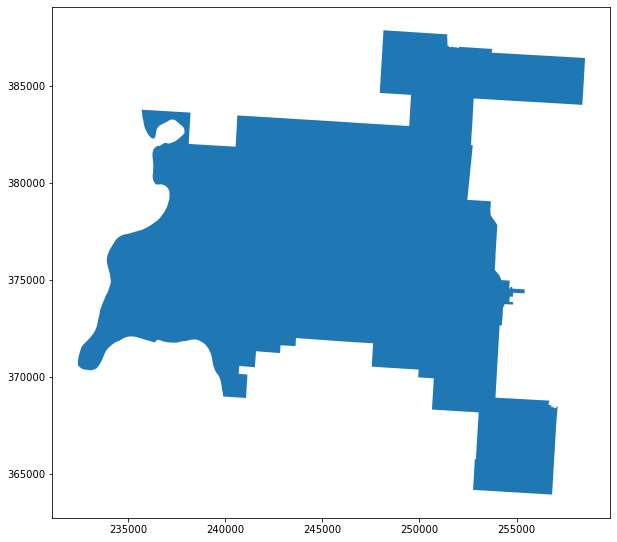

In [712]:
vest_mt_16[vest_mt_16['join_col'] =='047RON1'].plot(figsize=(10,10))

<AxesSubplot:>

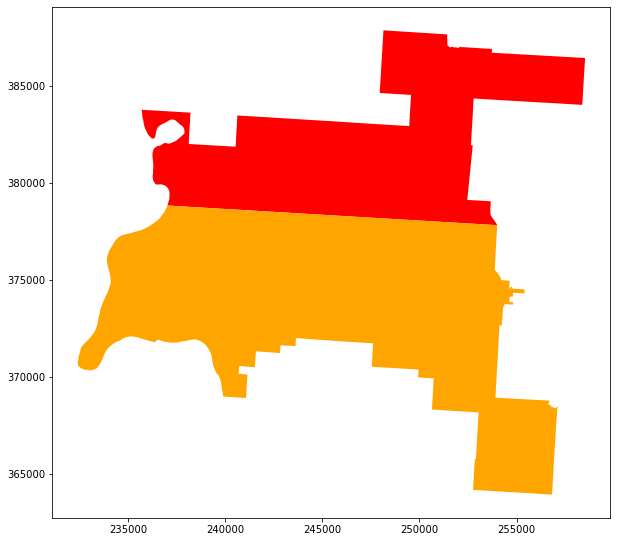

In [713]:
ax = mt_shp[mt_shp['join_col'] == '047PAB 1_HD93'].plot(color='red',figsize=(10,10))
mt_shp[mt_shp['join_col'] == '047RON1'].plot(ax=ax, color='orange')

<AxesSubplot:>

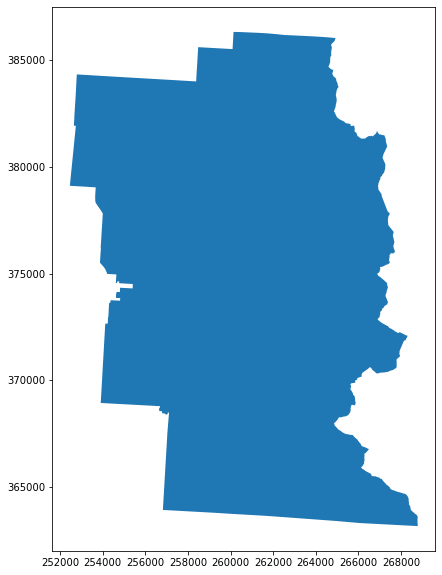

In [714]:
vest_mt_16[vest_mt_16['join_col'] =='047RON2'].plot(figsize=(10,10))

<AxesSubplot:>

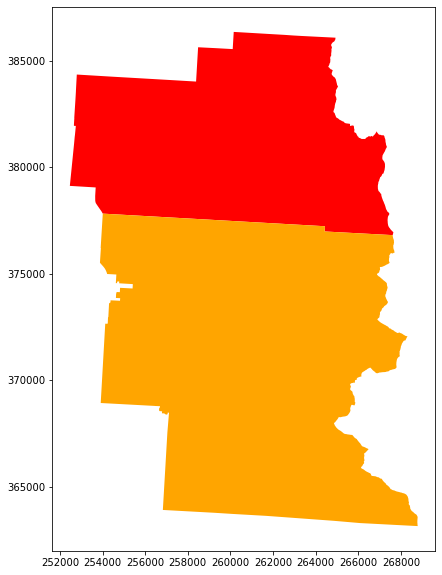

In [715]:
ax = mt_shp[mt_shp['join_col'] == '047PAB 2_HD15'].plot(color='red',figsize=(10,10))
mt_shp[mt_shp['join_col'] == '047RON2'].plot(ax=ax, color='orange')

## **Final Merge**

In [716]:
final_merge = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          632
left_only      34
right_only     32
Name: final_merge, dtype: int64

In [717]:
final_merge[final_merge['final_merge'] != 'both'][['COUNTY_x','NAME_x','COUNTY_y','NAME_y','join_col']]

,COUNTY_x,NAME_x,COUNTY_y,NAME_y,join_col
6,Carbon,P 1,NaN,NaN,009P 1
14,Big Horn,PRECINCT #1,NaN,NaN,003PRECINCT #1
42,Carbon,P 2,NaN,NaN,009P 2
50,Big Horn,PRECINCT #2,NaN,NaN,003PRECINCT #2
69,Carbon,P 3,NaN,NaN,009P 3
77,Big Horn,PRECINCT #3,NaN,NaN,003PRECINCT #3
96,Carbon,P 4,NaN,NaN,009P 4
102,Big Horn,PRECINCT #4,NaN,NaN,003PRECINCT #4
119,Carbon,P 5,NaN,NaN,009P 5
125,Big Horn,PRECINCT #5,NaN,NaN,003PRECINCT #5


# **Validate Geometry**

In [718]:
print(final_merge.columns)

Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN', 'G16HALDJUN', 'G16HALLBRE',
       'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN', 'G16ATGRFOX', 'G16ATGDJEN',
       'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO', 'G16AUDRROS', 'G16AUDDLAS',
       'G16SPIRARN', 'G16SPIDROM', 'geometry_y', 'final_merge'],
      dtype='object')


In [719]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    602
True      30
dtype: int64


1) For Carter - PRECINCT #1 ALZADA difference in area is 0.10173848064848712
2) For Garfield - PRECINCT 01 difference in area is 0.20917505437514466
3) For Treasure - Precinct 1 difference in area is 0.26515436623529864
4) For Golden Valley - RYEGATE difference in area is 0.7463098176672933
5) For Golden Valley - LAVINA difference in area is 0.5339707751821665
6) For Daniels - PRECINCT #2 difference in area is 0.598768562017123
7) For Sanders - 3-TROUT CREEK-HD13 difference in area is 0.11690597506341056
8) For Daniels - PRECINCT #3 difference in area is 1.1446534156013435
9) For Wheatland - PRECINCT 3 difference in area is 0.4668704769169927
10) For Sweet Grass - PRECINCT 3 difference in area is 0.8519442719450299
11) For Beaverhead - PRECINCT 04 difference in area is 0.23138583339645355
12) For Sweet Grass - PRECINCT 4 difference in area is 0.3708095171162503
13) For Prairie - PRECINCT NO. 4 difference in area is 0.4879000269396799
14) For Powder River - PRECINCT04 difference in area

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For Musselshell - PRECINCT 7 difference in area is 0.13209372082656248
23) For Rosebud - PRECINCT 7 difference in area is 0.31508017323668797
24) For Glacier - PCT 08 difference in area is 0.156885169893103
25) For Custer - SHEFFIELD MOON difference in area is 0.14838756690948202
26) For Stillwater - RAPELJE PRECINCT 9 difference in area is 0.19838520005277924
27) For Custer - S-H SCHOOL difference in area is 0.12303606403282971
28) For Stillwater - NYE PRECINCT 10 difference in area is 0.15433979264640915
29) For Rosebud - PRECINCT 10 difference in area is 0.31732014484474697
30) For Rosebud - PRECINCT 11 difference in area is 0.11338342288349024
31) For Powder River - PRECINCT11 difference in area is 0.1553007899655654
32) For Custer - SPRING CREEK SCH difference in area is 0.11207436672244589
33) For Powder River - PRECINCT12 difference in area is 0.12179593314979549
34) For Carter - PRECINCT #14 RURAL EKALAKA difference in area is 0.13170569385900072
35) For Garfield - PRECINCT

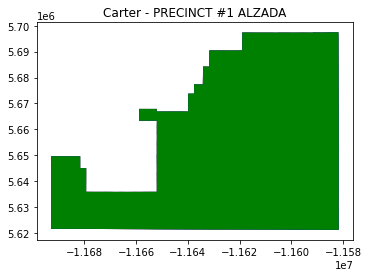

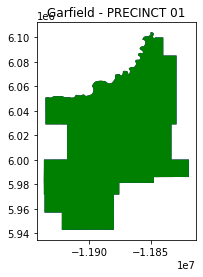

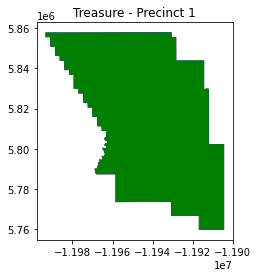

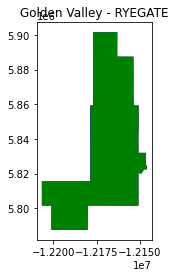

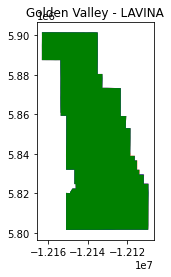

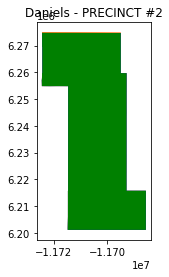

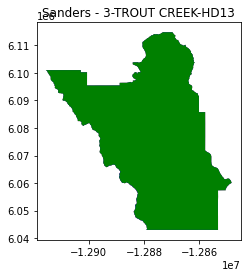

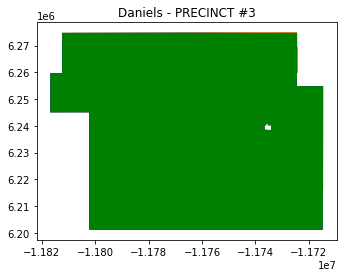

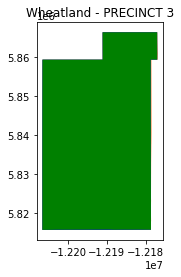

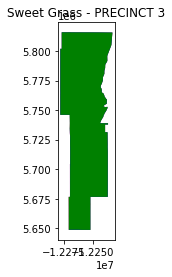

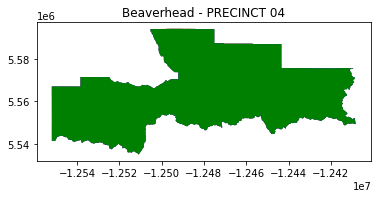

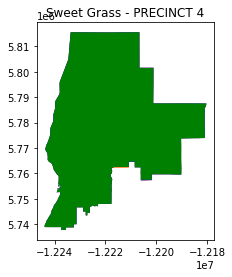

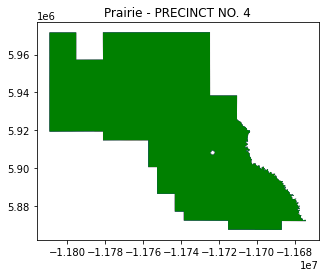

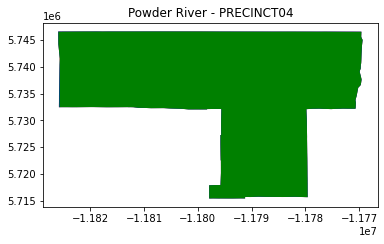

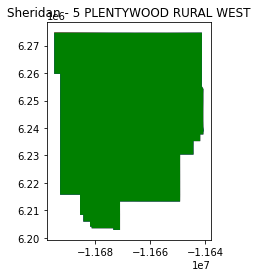

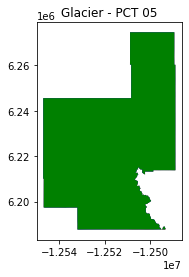

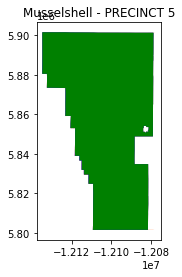

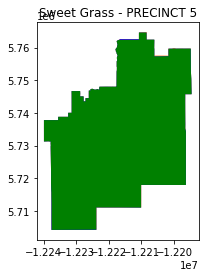

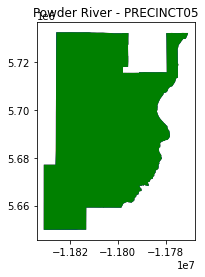

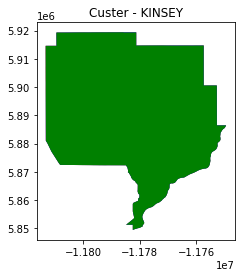

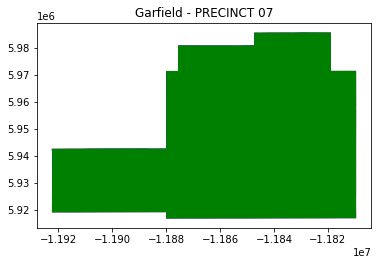

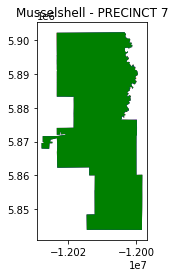

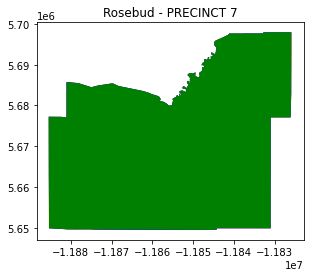

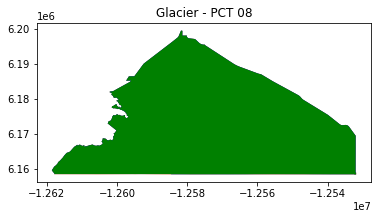

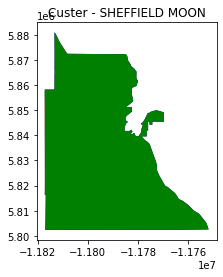

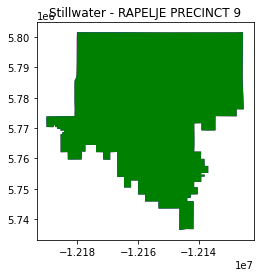

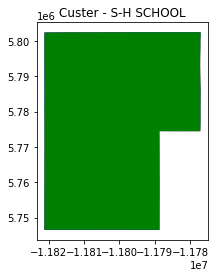

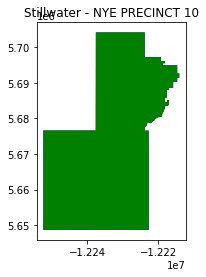

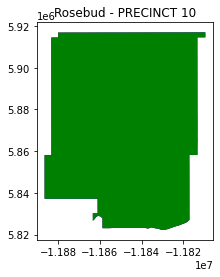

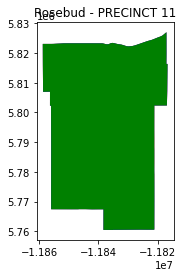

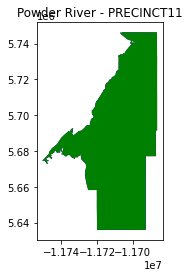

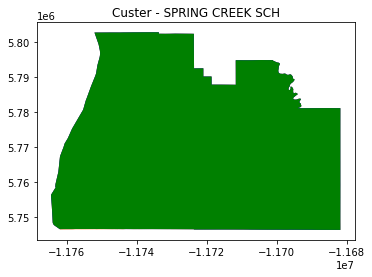

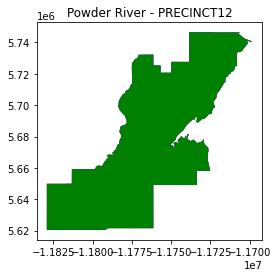

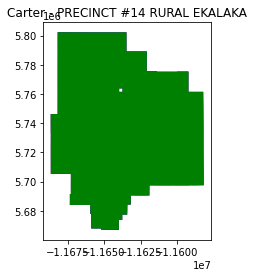

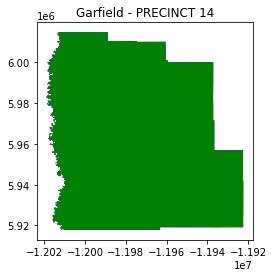

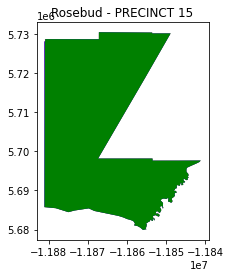

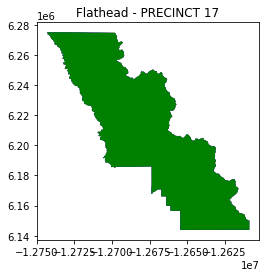

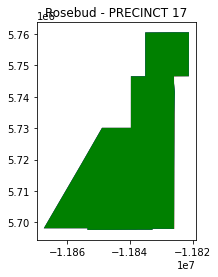

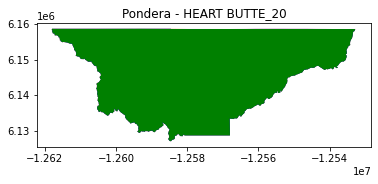

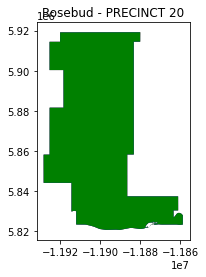

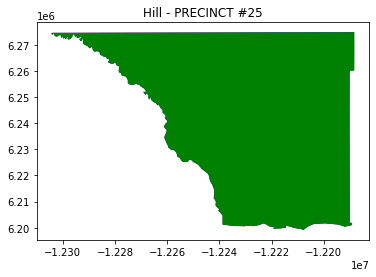

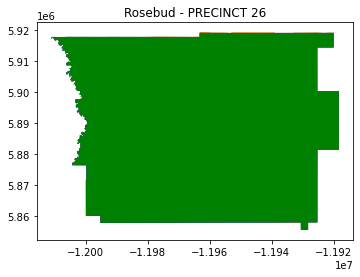

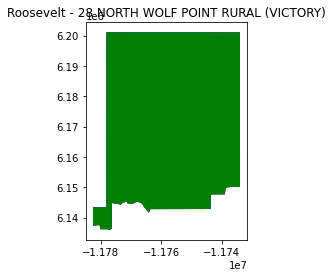

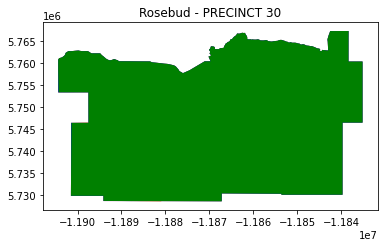

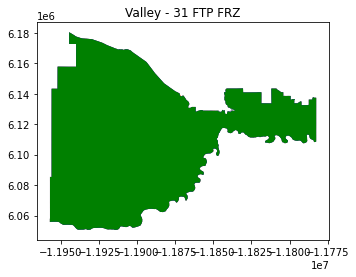

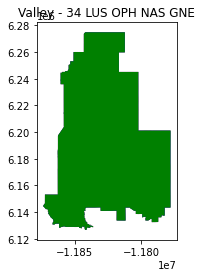

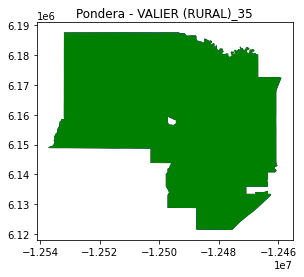

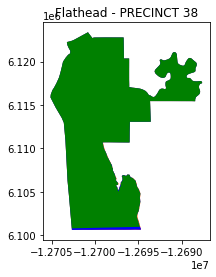

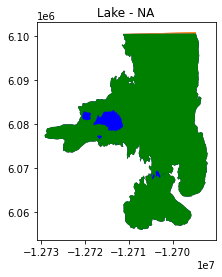

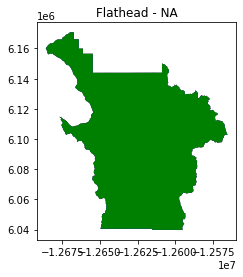

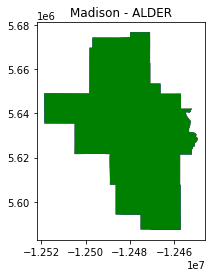

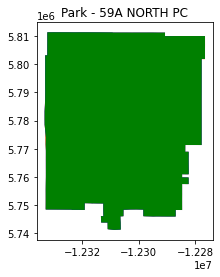

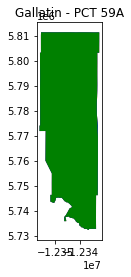

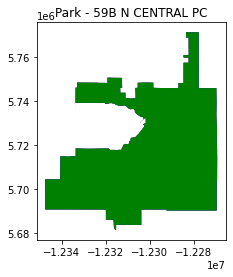

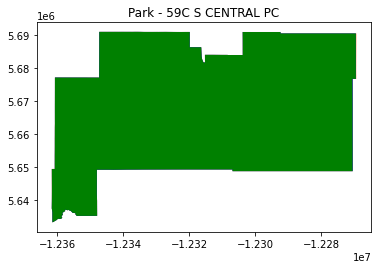

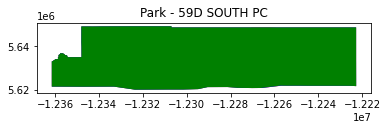

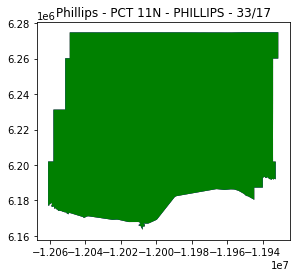

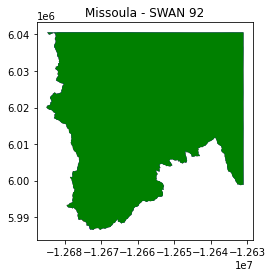

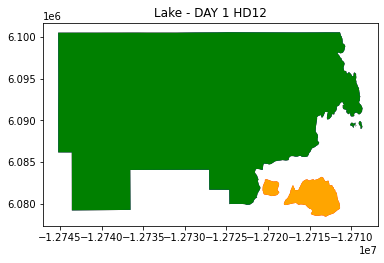

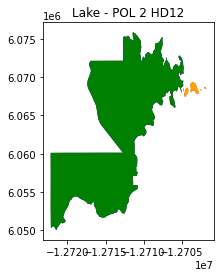

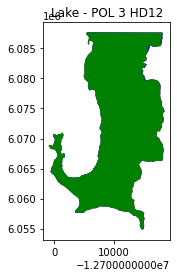

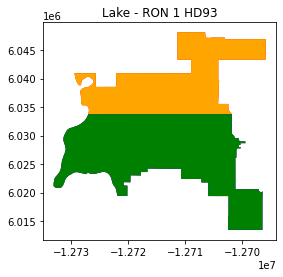

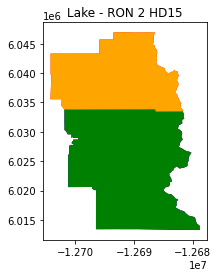

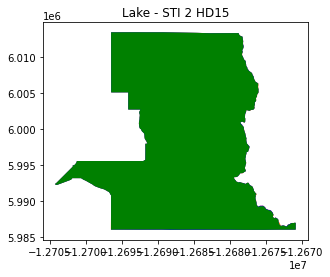

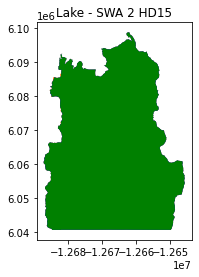

In [720]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,1]
        county = source_geoms.iat[i,5]
        
        print(str(count)+") For " + county + ' - ' + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(county + ' - ' + name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(county + ' - ' + name)

In [721]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(632, 1)
29 precincts w/ a difference of 0 km^2
538 precincts w/ a difference between 0 and .1 km^2
55 precincts w/ a difference between .1 and .5 km^2
5 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
2 precincts w/ a difference greater than 5 km^2


## **Look into Flathead Lake differences**

### It looks like VEST combined PAB 1 and RON 1 into one precinct

<AxesSubplot:>

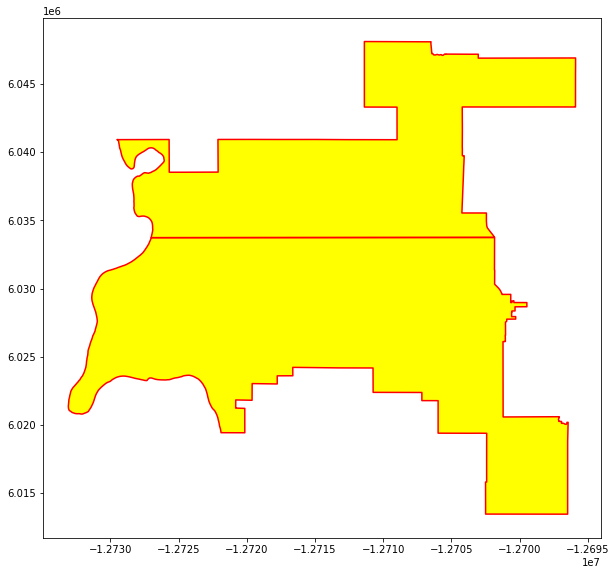

In [738]:
mt_shp = mt_shp.to_crs(3857)
vest_mt_16 = vest_mt_16.to_crs(3857)
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'RON 1 HD93'].plot(figsize=(10,10),color="yellow")
mt_shp[mt_shp['NAME'] == 'PAB 1_HD93'].boundary.plot(figsize=(10,10),ax=ax,color="red")
mt_shp[mt_shp['NAME'] == 'RON 1 HD93'].boundary.plot(figsize=(10,10),ax=ax,color="red")

### It looks like VEST combined PAB 2 and RON 2 into one precinct

<AxesSubplot:>

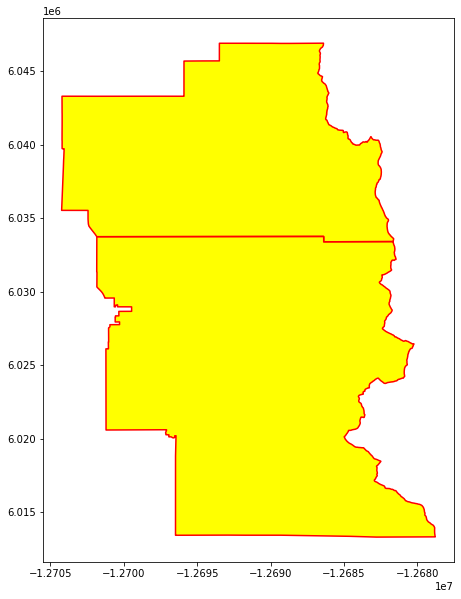

In [737]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'RON 2 HD15'].plot(figsize=(10,10),color="yellow")
mt_shp[mt_shp['NAME'] == 'PAB 2_HD15'].boundary.plot(figsize=(10,10),ax=ax,color="red")
mt_shp[mt_shp['NAME'] == 'RON 2 HD15'].boundary.plot(figsize=(10,10),ax=ax,color="red")

### It appears that VEST assigned islands in Flathead lake to precincts "DAY 1 HD12" and "POL 2 HD12" which caused the largest discrepencies between the SOS shapefile and VEST's

<AxesSubplot:>

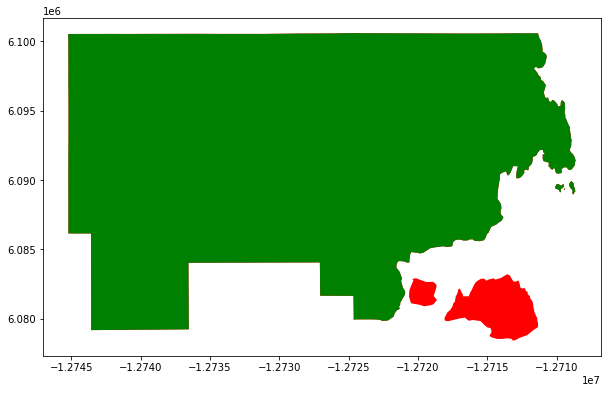

In [723]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'DAY 1 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'DAY 1 HD12'].plot(figsize=(10,10),ax=ax,color="green")

<AxesSubplot:>

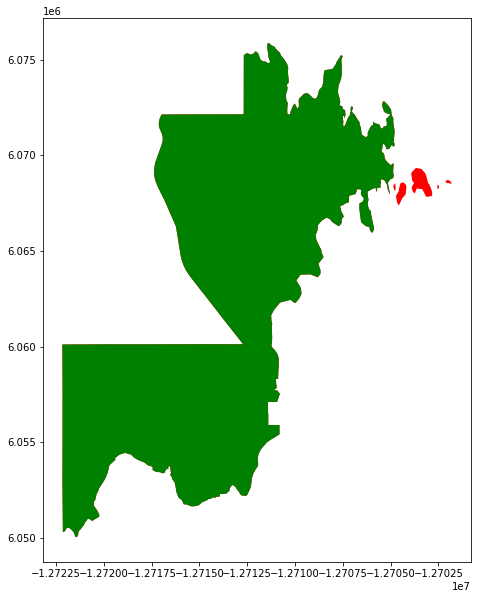

In [724]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'POL 2 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'POL 2 HD12'].plot(figsize=(10,10),ax=ax,color="green")

> The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley.

At the time of this writing, we do not have access to any of the county specific maps. 

> The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

Found these maps here that are PDFs but we can use to compare: 
https://www.lccountymt.gov/it/gis-maps/completed-maps/voting-precincts.html. No shapefiles available. 